In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as m
from scipy import interpolate
from scipy.signal import argrelextrema
import scipy
import statistics
import os
import seaborn as sns

## Column names

####
Dataset is delimited as CSV values as follows;

X ; Y; Azimuth; Pressure; Altitude; Timestamp; Test ID

----------------
Test ID: 
0: Static Spiral Test ( Draw on the given spiral pattern)
1: Dynamic Spiral Test ( Spiral pattern will blink in a certain time, so subjects need to continue on their draw)
2: Circular Motion Test (Subjectd draw circles around the red point)

In [ ]:
# global variables/parameters
n = 1000
smoothing_factor = 10000

In [ ]:
# return (velocity, acceleration, jerk, curvature)
def smoothCurveFeature(curve, n, smoothing_factor, df):
    sx = interpolate.UnivariateSpline(np.arange(curve.shape[1]), curve[0,:], k=4)
    sy = interpolate.UnivariateSpline(np.arange(curve.shape[1]), curve[1,:], k=4)
    pressure_f = interpolate.UnivariateSpline(np.arange(np.shape(df[3])[0]), np.array(df[3]), k=1)

    sx.set_smoothing_factor(smoothing_factor)
    sy.set_smoothing_factor(smoothing_factor)

    sxdot = sx.derivative()
    sydot = sy.derivative()
    
    sxdotdot = sxdot.derivative()
    sydotdot = sydot.derivative()

    sxdotdotdot = sxdotdot.derivative()
    sydotdotdot = sydotdot.derivative()
    
    t = np.linspace(0, curve.shape[1], n)
    new_curve = np.zeros((2, n))
    new_curve[0,:] = sx(t)
    new_curve[1,:] = sy(t)

    #calculate velocity
    velocity = np.sqrt((sydot(t))**2 + (sxdot(t))**2)

    #calculate acceleration
    acceleration = np.sqrt((sydotdot(t))**2 + (sxdotdot(t))**2)

    #calculate jerk
    jerk = np.sqrt((sydotdotdot(t))**2 + (sxdotdotdot(t))**2)
    
    # calculate curvature
    curvature = (sxdot(t) * sydotdot(t) - sydot(t) * sxdotdot(t))/(sxdot(t)**2 + sydot(t)**2)**(3/2)

    pressure = pressure_f(t)
    
    # new_curve: interpolated/transformed curve, curv_spline_eval: curvature, curv_dot_eval: rate of change of curvature
    return velocity, acceleration, jerk, curvature, pressure

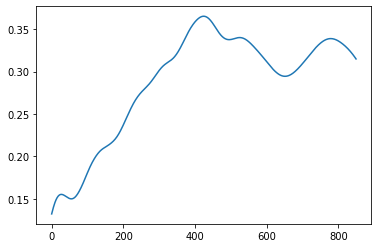

In [ ]:
df = pd.read_csv('/work/ParkinsonHW/C_0009.txt', sep = ';', header = None)
x = df[df[6] == 0][0]
y = df[df[6] == 0][1]
curve = np.array([x, y])
velocity, _, _, _, _ = smoothCurveFeature(curve, 1000, 100000, df)
plt.plot(velocity[50:len(velocity)-100])

## List of Control & Static Files

In [ ]:
# all the control drawings
controlFiles = []
for i in range(1, 16): 
    if i < 10: 
        controlFiles.append('/work/ParkinsonHW/C_000' + str(i) + '.txt')
    else: 
        controlFiles.append('/work/ParkinsonHW/C_00' + str(i) + '.txt')

patientFiles = []
directory = os.fsencode('/work/ParkinsonHW')
for file in os.listdir(directory): 
    filename = os.fsdecode(file)
    if filename[0] == 'P' or filename[0] == 'H': 
        path = os.path.join('/work/ParkinsonHW', filename)
        patientFiles.append(path)

## Feature Calculation Functions

In [ ]:
# duration
def duration_calc(timestamps): 
    total_duration = max(timestamps) - min(timestamps)
    return total_duration

# total displacement
def total_displacement_calc(displacement): 
    total_displacement = np.sum(np.array(displacement))
    return total_displacement

In [ ]:
# mean velocity
def velocity_mean(velocity): 
    return np.mean(velocity)

# median velocity
def velocity_median(velocity): 
    return np.median(velocity)

# max velocity
def velocity_max(velocity): 
    return np.max(velocity)

# velocity std
def velocity_std(velocity): 
    return np.std(velocity)

# rate of inversions in velocity (niv)
def velocity_niv(velocity): 
    maximum = argrelextrema(np.array(velocity), np.greater)   
    return len(maximum[0]) / duration_calc(timestamps)

# normal velocity variability
def velocity_nvv(velocity): 
    sigma_sum = 0
    for i in range(1, len(velocity) - 1): 
        sigma_sum += abs(velocity[i+1] - velocity[i])
    T = duration_calc(timestamps)
    nvv = 1/(T * abs(velocity_mean(velocity))) * sigma_sum
    return nvv

In [ ]:
# mean acceleration
def accel_mean(acceleration):
    return np.mean(acceleration)

# max acceleration
def accel_max(acceleration):
    return np.max(acceleration)
    
# median acceleration
def accel_median(acceleration): 
    return np.median(acceleration)

# acceleration std
def accel_std(acceleration):
    return np.std(acceleration)

# rate of inversions in acceleration (nia): 
def accel_nia(acceleration):
    maximum = argrelextrema(np.array(acceleration), np.greater)    
    return len(maximum[0]) / duration_calc(timestamps)

In [ ]:
# mean jerk
def jerk_mean(jerk):
    return np.mean(jerk)

# max jerk
def jerk_max(jerk):
    return np.max(jerk)
    
# median jerk
def jerk_median(jerk): 
    return np.median(jerk)

# jerk std
def jerk_std(jerk):
    return np.std(jerk)

# rate of inversions in jerk (nij) (time-normalized):  
def jerk_nij(jerk):
    maximum = argrelextrema(np.array(jerk), np.greater)    
    return len(maximum[0]) / duration_calc(timestamps)

In [ ]:
# number of inversions in curvature (time-normalized)
def curvature_nic(curvature): 
    maximum = argrelextrema(np.array(curvature), np.greater)    
    return len(maximum[0]) / duration_calc(timestamps)

# true curvature at each point? 

In [ ]:
# mean pressure
def pressure_mean(pressure):
    return np.mean(pressure)

# max pressure
def pressure_max(pressure):
    return np.max(pressure)
    
# median pressure
def pressure_median(pressure): 
    return np.median(pressure)

# pressure std
def pressure_std(pressure):
    return np.std(pressure)
    
# rate of change of pressure inversions
def rip(pressure): 
    maximum = argrelextrema(np.array(pressure), np.greater)    
    return len(maximum[0]) / duration_calc(timestamps)

# Rate of Inversion in Pressure

In [ ]:
rips = []
patientState = []
for filename in controlFiles: 
    df = pd.read_csv(filename, sep = ';', header = None)
    timestamps = df[df[6] == 0][5]
    final = rip(df[df[6] == 0][3])
    rips.append(final)
    patientState.append("Control")

for filename in patientFiles:
    df = pd.read_csv(filename, sep = ';', header = None)
    timestamps = df[df[6] == 0][5]
    final = rip( df[df[6] == 0][3])
    rips.append(final)
    patientState.append("Patients")

<AxesSubplot:>

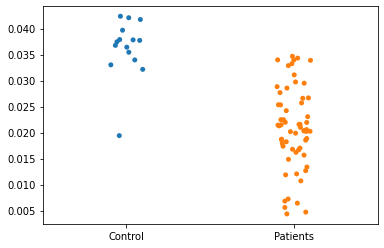

In [ ]:
sns.stripplot(x = patientState, y = rips)

In [ ]:
df = pd.read_csv('/work/ParkinsonHW/H_P000-0004.txt', sep = ';', header = None)
df_static = df[(df[6] == 0)]
x = df_static[0]
y = df_static[1]
t = df_static[5]
curve = np.array([x, y])
smoothing_factor = 100000
velocity, acceleration, jerk, curvature, pressure = smoothCurveFeature(curve, n, smoothing_factor, df_static)
timestamps = df_static[5]

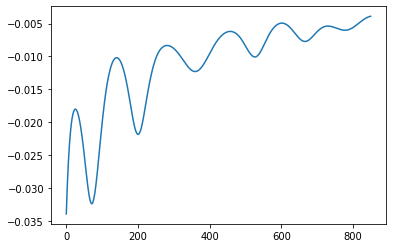

In [ ]:
plt.plot(curvature[50: len(curvature)-100])
plt.show()

## 

# Static Drawings

In [ ]:
# How much data to exclude on the ends. We want to make the a factor based on the length of the data in each file
EndRemove = 200
# constructs the Pandas DataFrame for gathering all the features 
subject_id = []
mean_vel = []
median_vel = []
max_vel = []
vel_std = []
vel_niv = [] #rate
nvv = [] 
mean_accel = []
max_accel = []
median_accel = []
std_accel = []
nia_accel = [] #rate
mean_jerk = []  
max_jerk = []
median_jerk = []
std_jerk = []
nij = [] #rate
nic = [] #rate
mean_pressure = []
median_pressure = []
max_pressure = []
std_pressure = []
#total_displacement = []
duration = []
category = []
rate_ip = []

# all the control static drawings
for i in range(1, 16): 
    if i < 10: 
        df = pd.read_csv('/work/ParkinsonHW/C_000' + str(i) + '.txt', sep = ';', header = None)
    else: 
        df = pd.read_csv('/work/ParkinsonHW/C_00' + str(i) + '.txt', sep = ';', header = None)
    df_static = df[(df[6] == 0)]
    x = df_static[0]
    y = df_static[1]
    t = df_static[5]
    curve = np.array([x, y])
    velocity, acceleration, jerk, curvature, pressure = smoothCurveFeature(curve, n, smoothing_factor)
    
    # truncating data
    velocity = velocity[100: len(velocity)-100]
    acceleration = acceleration[100:len(acceleration)-100]
    jerk = jerk[100:len(jerk)-100]
    pressure = pressure[100: len(pressure)-100]
    curvature = curvature[100:len(curvature)-100]

    timestamps = df_static[5]
    
    subject_id.append('C' + str(i))

    mean_vel.append(velocity_mean(velocity))
    median_vel.append(velocity_median(velocity))
    max_vel.append(velocity_max(velocity))
    vel_std.append(velocity_std(velocity))
    vel_niv.append(velocity_niv(velocity))
    nvv.append(velocity_nvv(velocity))

    mean_accel.append(accel_mean(acceleration))
    median_accel.append(accel_median(acceleration))
    max_accel.append(accel_max(acceleration))
    std_accel.append(accel_std(acceleration))
    nia_accel.append(accel_nia(acceleration))

    mean_jerk.append(jerk_mean(jerk))
    median_jerk.append(jerk_median(jerk))
    max_jerk.append(jerk_max(jerk))
    std_jerk.append(jerk_std(jerk))
    nij.append(jerk_nij(jerk))

    nic.append(curvature_nic(curvature))

    duration.append(duration_calc(timestamps))
    #total_displacement.append(total_displacement_calc(displacement))

    mean_pressure.append(pressure_mean(pressure))
    max_pressure.append(pressure_max(pressure))
    median_pressure.append(pressure_median(pressure))
    std_pressure.append(pressure_std(pressure))
    rate_ip.append(rip(pressure))

    category.append(0)

# all the PD static drawings 
directory = os.fsencode('/work/ParkinsonHW')
for file in os.listdir(directory): 
    filename = os.fsdecode(file)
    if filename[0] == 'P' or filename[0] == 'H': 
        path = os.path.join('/work/ParkinsonHW', filename)
        df = pd.read_csv(path, sep = ';', header = None)
        
        if 0 not in list(df[6]):
            continue
        df_static = df[(df[6]==0)]
        x = df_static[0]
        y = df_static[1]
        t = df_static[5]
        curve = np.array([x, y])
        velocity, acceleration, jerk, curvature, pressure = smoothCurveFeature(curve, n, smoothing_factor)
        timestamps = df_static[5]


        #velocity = velocity[10: len(velocity)-100]
        #acceleration = acceleration[30:len(acceleration)-50]
        #jerk = jerk[30:len(jerk)-50]
        #pressure = pressure[100: len(pressure)-20]

        velocity = velocity[100: len(velocity)-100]
        acceleration = acceleration[100:len(acceleration)-100]
        jerk = jerk[100:len(jerk)-100]
        pressure = pressure[100: len(pressure)-100]
        curvature = curvature[100:len(curvature)-100]
        subject_id.append(filename[:-4])

        mean_vel.append(velocity_mean(velocity))
        median_vel.append(velocity_median(velocity))
        max_vel.append(velocity_max(velocity))
        vel_std.append(velocity_std(velocity))
        vel_niv.append(velocity_niv(velocity))
        nvv.append(velocity_nvv(velocity))

        mean_accel.append(accel_mean(acceleration))
        median_accel.append(accel_median(acceleration))
        max_accel.append(accel_max(acceleration))
        std_accel.append(accel_std(acceleration))
        nia_accel.append(accel_nia(acceleration))

        mean_jerk.append(jerk_mean(jerk))
        median_jerk.append(jerk_median(jerk))
        max_jerk.append(jerk_max(jerk))
        std_jerk.append(jerk_std(jerk))
        nij.append(jerk_nij(jerk))

        nic.append(curvature_nic(curvature))

        duration.append(duration_calc(timestamps))
        #total_displacement.append(total_displacement_calc(displacement))

        mean_pressure.append(pressure_mean(pressure))
        max_pressure.append(pressure_max(pressure))
        median_pressure.append(pressure_median(pressure))
        std_pressure.append(pressure_std(pressure))
        rate_ip.append(rip(pressure))

        # 1 meaning patient data
        category.append(1)

features_df_static = pd.DataFrame({
    'Subject ID': subject_id,
    'Category' : category,
    'Mean Velocity': mean_vel, 'Velocity Std': vel_std, 'Peak Velocity': max_vel, 'NVV': nvv, 'NIV': vel_niv, 
    'Mean Acceleration': mean_accel, 'Acceleration Std': std_accel, 'Peak Acceleration': max_accel, 'NIA': nia_accel, 
    'Mean Jerk': mean_jerk, 'Jerk Std': std_jerk, 'Max Jerk': max_jerk, 'NIJ': nij, 
    'NIC': nic, 
    'Duration': duration, 
    #'Total Displacement': total_displacement, 
    'Mean Pressure': mean_pressure, 'Median Pressure': median_pressure, 'Peak Pressure': max_pressure, 'Pressure Std': std_pressure, 'Rate of Inversion in Pressure': rate_ip
    }) 

TypeError: smoothCurveFeature() missing 1 required positional argument: 'df'

In [ ]:
filename = 'lengthData_static_HW_features.csv'
features_df_static.to_csv (filename, index = False, header=True)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes 

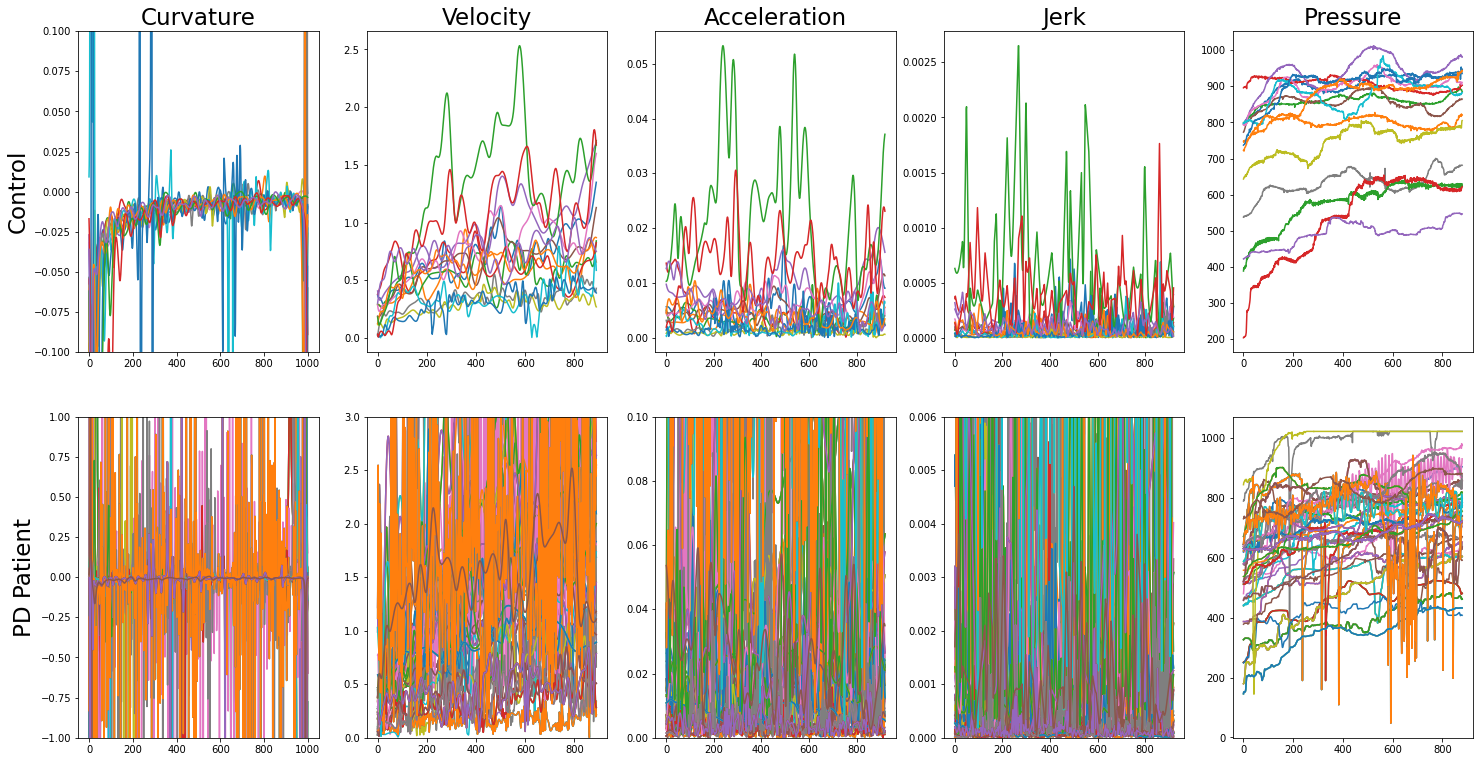

In [ ]:
# figures of velocity, acceleration, jerk and curvature after smoothing 
plt.figure(figsize = (25, 13))

# Control
for i in range(1, 16): 
    if i < 10: 
        df = pd.read_csv('/work/ParkinsonHW/C_000' + str(i) + '.txt', sep = ';', header = None)
    else: 
        df = pd.read_csv('/work/ParkinsonHW/C_00' + str(i) + '.txt', sep = ';', header = None)
    df_static = df[(df[6] == 0)]
    x = df_static[0]
    y = df_static[1]
    t = df_static[5]
    curve = np.array([x, y])
    velocity, acceleration, jerk, curvature, pressure = smoothCurveFeature(curve, n, smoothing_factor)

    velocity = velocity[10: len(velocity)-100]
    acceleration = acceleration[30:len(acceleration)-50]
    jerk = jerk[30:len(jerk)-50]
    pressure = pressure[100: len(pressure)-20]
    
    plt.subplot(2, 5, 1)
    plt.plot(curvature)
    plt.ylim(-0.1, 0.1)
    plt.title('Curvature', fontsize = 23)
    plt.ylabel('Control', fontsize = 23)
    plt.subplot(2, 5, 2)
    plt.plot(velocity)
    plt.title('Velocity', fontsize = 23)
    plt.subplot(2, 5, 3)
    plt.plot(acceleration)
    plt.title('Acceleration', fontsize = 23)
    plt.subplot(2, 5, 4)
    plt.plot(jerk)
    plt.title('Jerk', fontsize = 23)
    plt.subplot(2, 5, 5)
    plt.plot(pressure)
    plt.title('Pressure', fontsize = 23)

# Patients
#plt.figure(figsize = (15, 5))
directory = os.fsencode('/work/ParkinsonHW')
for file in os.listdir(directory): 
    filename = os.fsdecode(file)
    if filename[0] ==  'H' and int(filename[9:11]) <= 43:
    #if filename[0] == 'P' or filename[0] == 'H': 
        path = os.path.join('/work/ParkinsonHW', filename)
        df = pd.read_csv(path, sep = ';', header = None)
        
        if 0 not in list(df[6]):
            continue
        df_static = df[(df[6]==0)]
        x = df_static[0]
        y = df_static[1]
        t = df_static[5]
        curve = np.array([x, y])
        velocity, acceleration, jerk, curvature, pressure = smoothCurveFeature(curve, n, smoothing_factor)
        '''acceleration = smoothCurveFeature(curve, n, smoothing_factor)[1]
        jerk = smoothCurveFeature(curve, n, smoothing_factor)[2]
        curvature = smoothCurveFeature(curve, n, smoothing_factor)[3]
        pressure = df_static[3]'''
        
        timestamps = df_static[5]

        velocity = velocity[10: len(velocity)-100]
        acceleration = acceleration[30:len(acceleration)-50]
        jerk = jerk[30:len(jerk)-50]
        pressure = pressure[100: len(pressure)-20]

    plt.subplot(2, 5, 6)
    plt.plot(curvature)
    plt.ylabel('PD Patient', fontsize = 23)
    plt.ylim(-1, 1)
    plt.subplot(2, 5, 7)
    plt.plot(velocity)
    plt.ylim(0, 3)
    plt.subplot(2, 5, 8)
    plt.plot(acceleration)
    plt.ylim(0, 0.1)
    plt.subplot(2, 5, 9)
    plt.plot(jerk)
    plt.ylim(0, 0.006)
    plt.subplot(2, 5, 10)
    plt.plot(pressure)

## Altitude (Grip Angle) & Azimuth (Z)

### Smoothing Azimuth with UnivariateSpline
##### (probably don't want to look at azimuth for ParkinsonHW, as they don't seem to have been measured correctly)
##### (also might need to do threshold stuff with altitude, see red patient graphs)

In [ ]:
def altitudePreventOverflow(csv_path):
    count = 0
    df = pd.read_csv(csv_path, sep = ';', header = None)
    altitude_read = df[4]
    threshold = 3000
    overflow = 3600
    altitude = []
    # accounts for jumps
    #threshold = 0.4
    if 0 in altitude_read: 
        for i in altitude_read: 
            if i > threshold: 
                i -= overflow
            altitude.append(i)
            if i > 1500 and i <3000:
                count += 1
    else: 
        altitude = altitude_read
    print(count)
    print(min(altitude))
    print(altitude.index(min(altitude)))
    return altitude_read, altitude

0
360
5527
0
360
5527


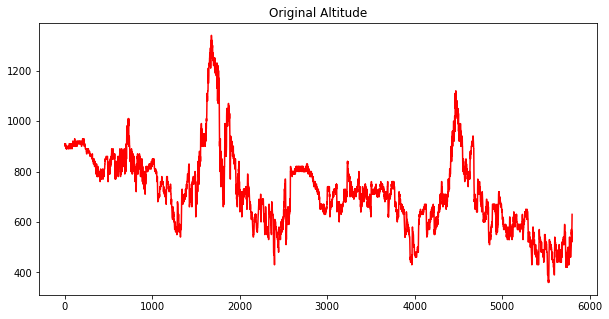

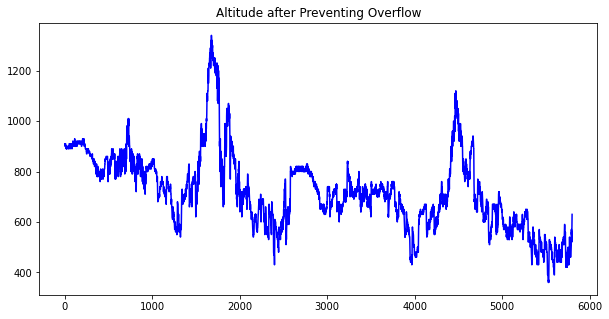

In [ ]:
# ParkinsonHW df[4] is altitude

altitude_read = altitudePreventOverflow(filename)[0]
altitude = altitudePreventOverflow(filename)[1]
plt.figure(figsize=[10,5])
plt.title('Original Altitude')
plt.plot(altitude_read, 'r')
plt.figure(figsize=[10,5])
plt.title('Altitude after Preventing Overflow')
plt.plot(altitude, 'b')

### Azimuth after smoothing & Altitude Plots

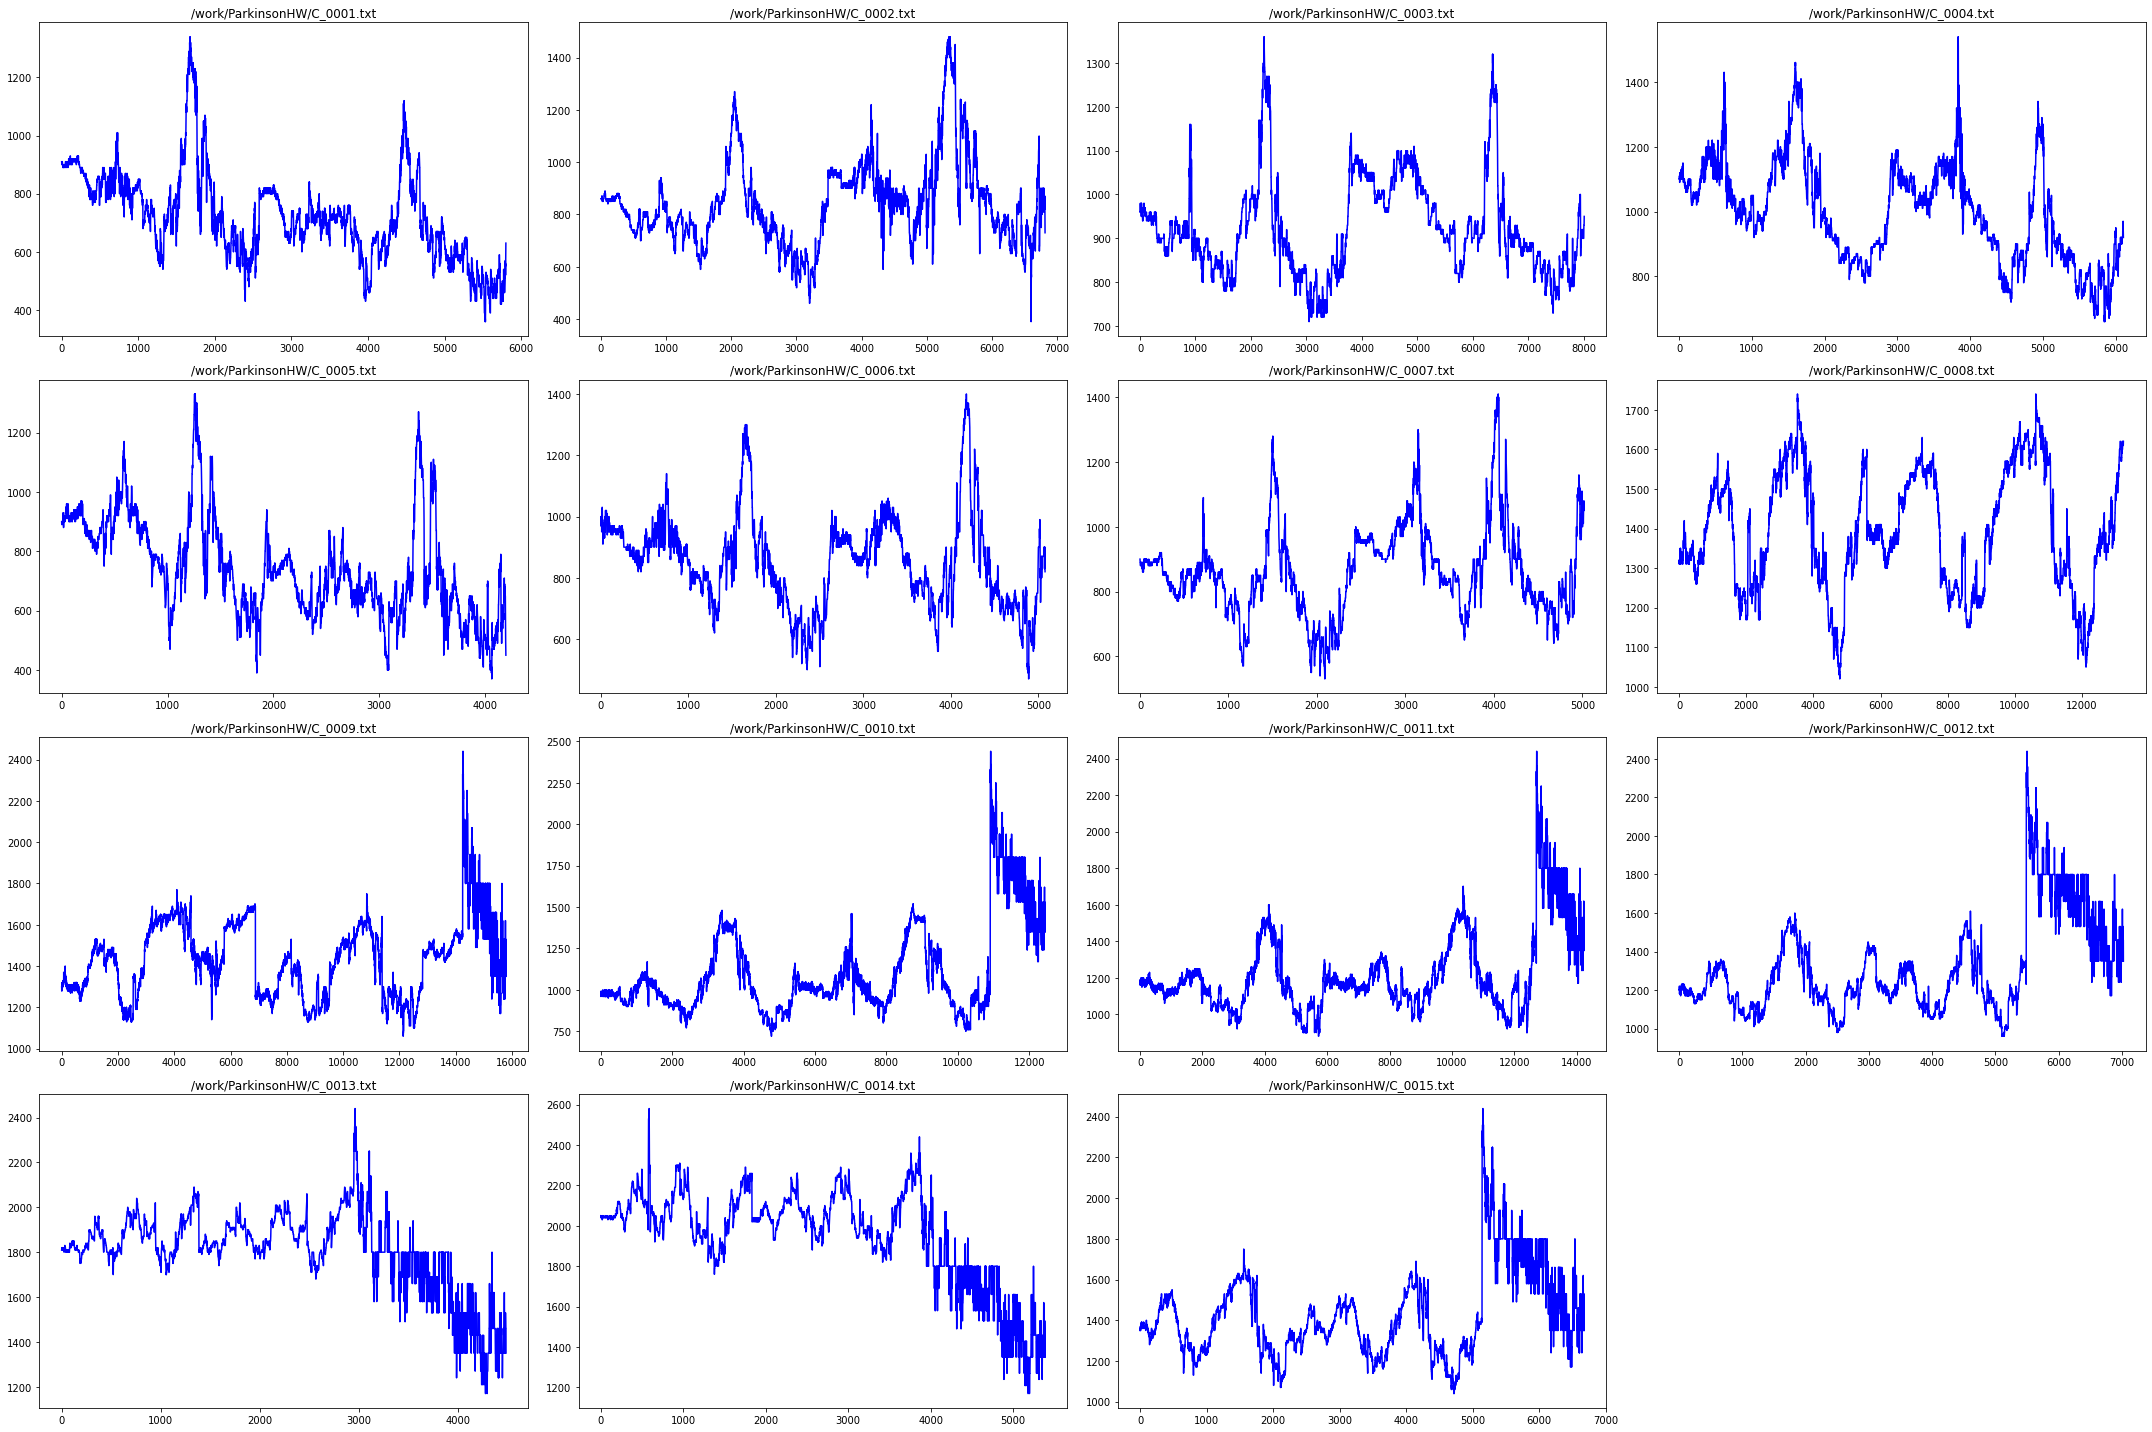

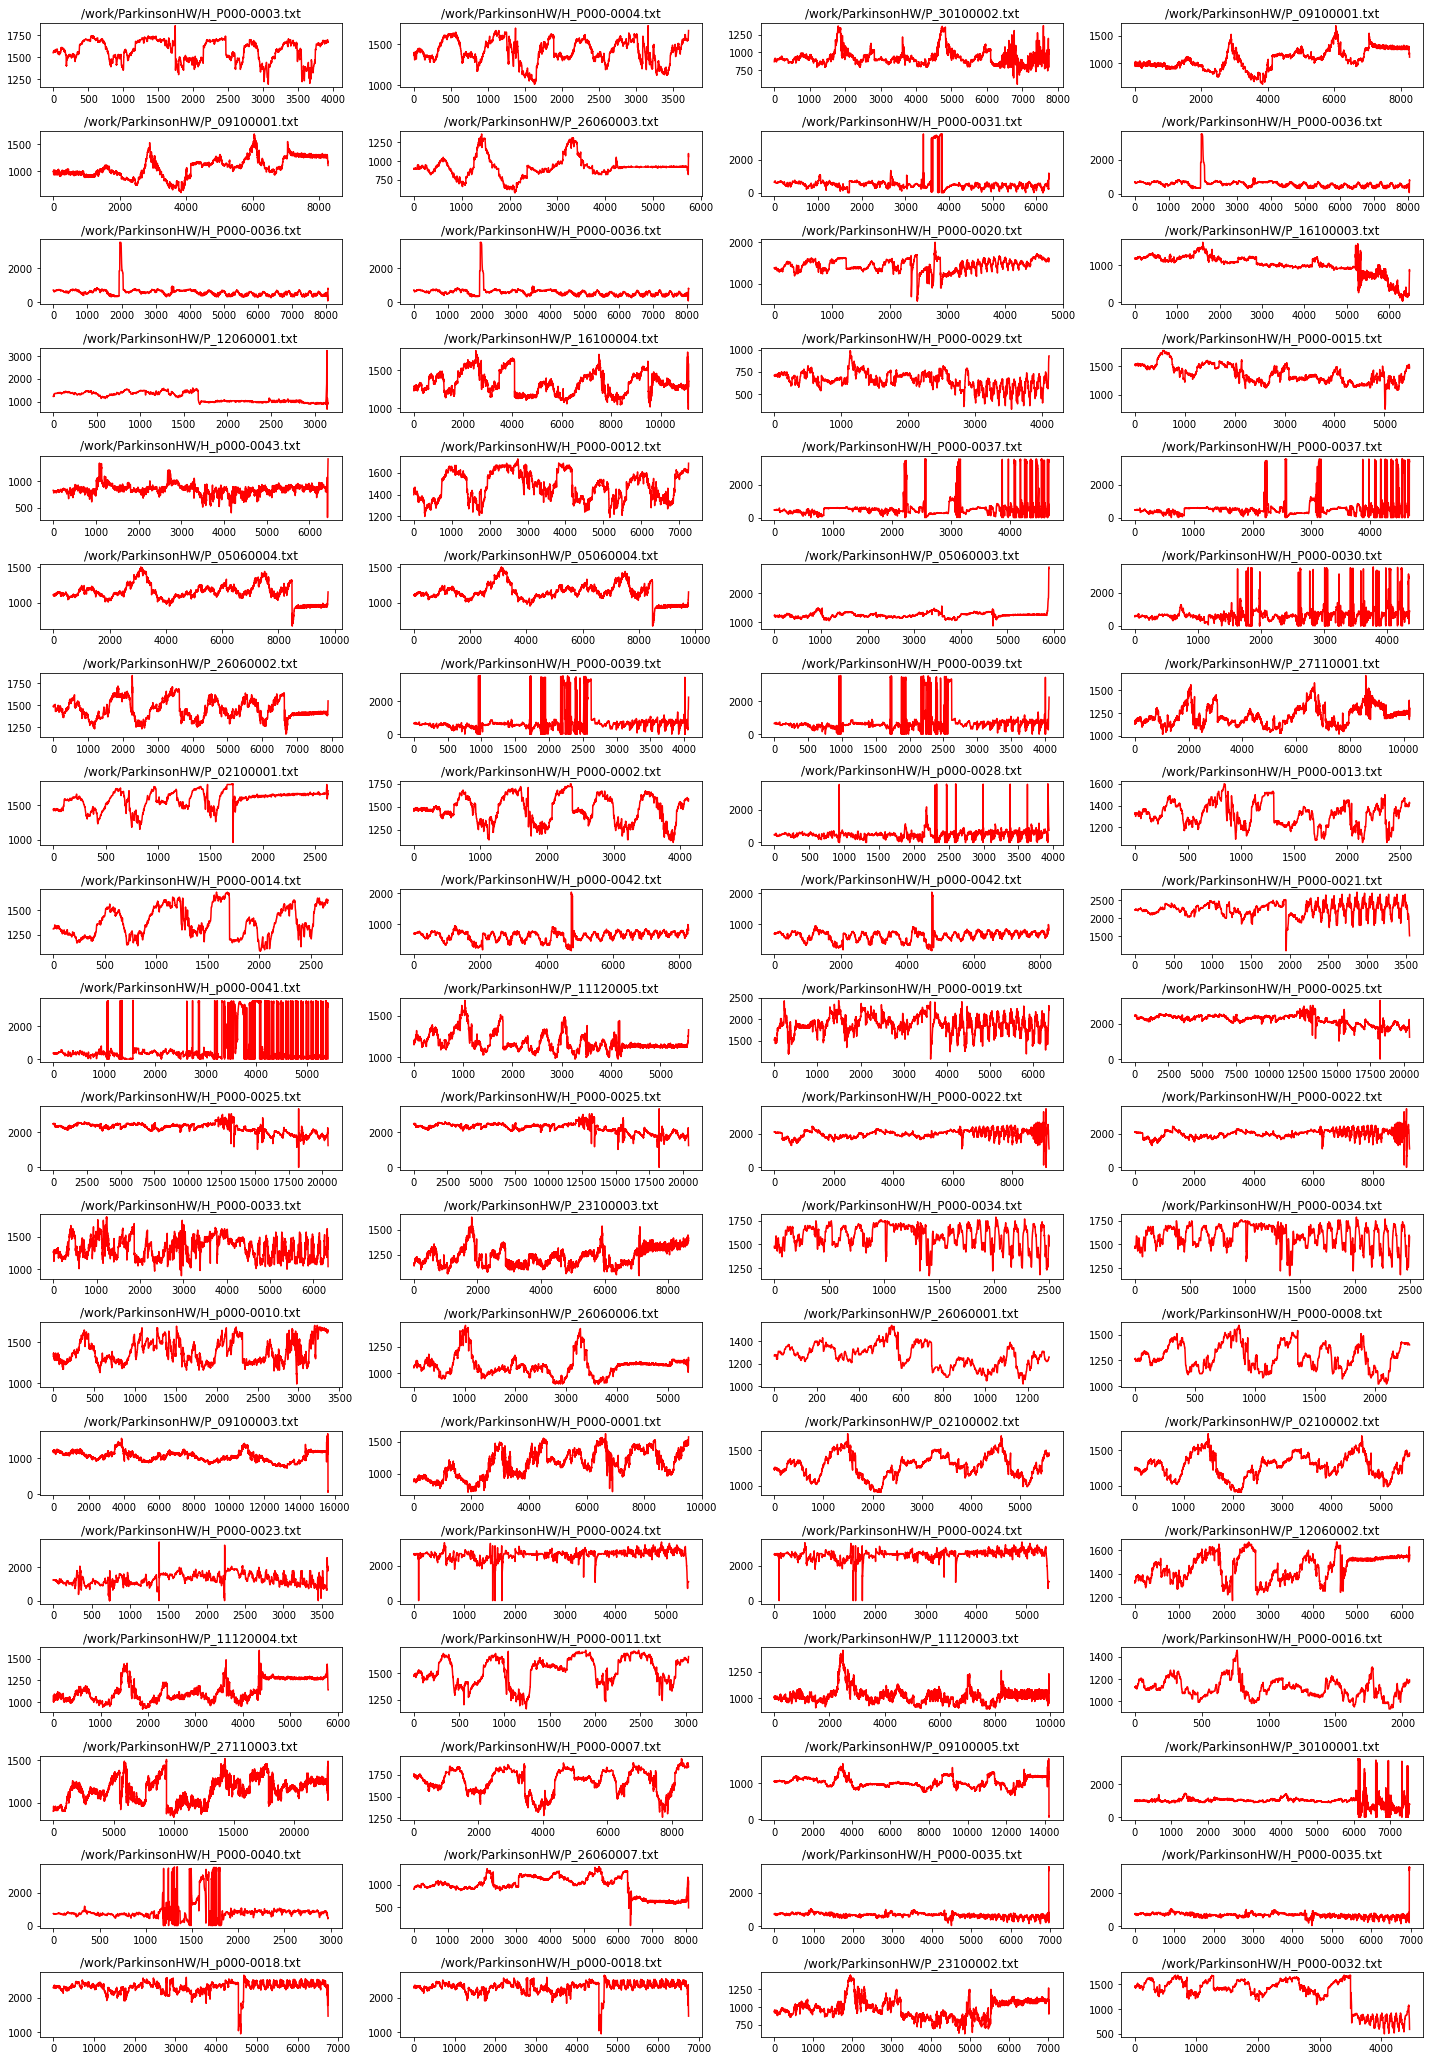

In [ ]:

# Control Altitudes
plt.figure(figsize = (30, 20), tight_layout = True)
for i in range(1, 16): 
    if i < 10: 
        filename = '/work/ParkinsonHW/C_000' + str(i) + '.txt'
    else: 
        filename = '/work/ParkinsonHW/C_00' + str(i) + '.txt'
    df = pd.read_csv(filename, sep = ";", header = None)
    altitude = df[4]
    plt.subplot(4, 4, i)
    plt.title(filename)
    plt.plot(altitude, 'b')

# PD Altitudes
plt.figure(figsize = (20, 30), tight_layout = True)
count = 1
directory = os.fsencode('/work/ParkinsonHW')
for file in os.listdir(directory): 
    filename = os.fsdecode(file)
    if filename[0] == 'P' or filename[0] == 'H': 
        path = os.path.join('/work/ParkinsonHW', filename)
        df = pd.read_csv(path, sep = ';', header = None)
    if 0 not in list(df[6]):
        continue
    altitude = df[4]
    plt.subplot(20, 4, count)
    plt.title(path)
    plt.plot(altitude, 'r')
    count += 1


0
360
5527
0
390
6600
0
710
3046
2
660
5844
0
370
4064
0
470
4889
0
530
2089
3931
1020
4784
5466
1060
12127
1138
720
4780
1642
880
5720
1347
960
5104
4088
1170
4281
4987
1170
5180
1932
1040
4717
2674
1190
3078
1231
1010
1628
0
550
6859
88
610
3839
88
610
3839
0
580
2105
0
-320
3620
71
-550
1992
71
-550
1992
71
-550
1992
1762
590
2477
17
40
6306
158
-400
3142
1692
990
11126
0
330
3548
1139
750
5015
0
310
6425
3286
1190
5168
32
-590
2243
32
-590
2243
0
670
8487
0
670
8487
35
880
4689
49
-580
4337
2419
1170
6681
58
-560
2269
58
-560
2269
131
1020
1032
1970
960
1718
1743
1110
3890
16
-480
3926
136
1060
2145
758
1090
2003
36
140
4742
36
140
4742
3541
1090
1952
93
-590
3639
123
980
3267
6072
1080
3624
20280
-590
12572
20280
-590
12572
20280
-590
12572
9064
-450
9138
9064
-450
9138
888
900
2954
89
1040
7087
1890
1170
1408
1890
1170
1408
848
990
2979
0
900
2780
18
1020
1179
67
1020
2026
30
50
15612
339
710
1882
493
910
2104
493
910
2104
947
-450
2237
5172
-590
622
5172
-590
622
2810
1170
2195


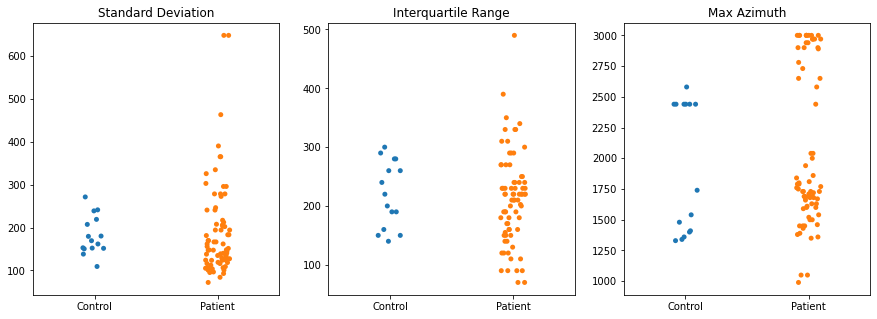

In [ ]:
# strip plots of altitude
std = []
iqr = []
xvalue = []
max_altitude = []
# controls
for i in range(1, 16): 
    if i < 10: 
        filename = '/work/ParkinsonHW/C_000' + str(i) + '.txt'
    else: 
        filename = '/work/ParkinsonHW/C_00' + str(i) + '.txt'
    altitude = altitudePreventOverflow(filename)[1]
    std.append(np.std(altitude))
    iqr.append(np.quantile(altitude, 0.75) - np.quantile(altitude, 0.25))
    max_altitude.append(np.max(altitude))
    xvalue.append('Control')

# patients
directory = os.fsencode('/work/ParkinsonHW')
for file in os.listdir(directory): 
    filename = os.fsdecode(file)
    if filename[0] == 'P' or filename[0] == 'H': 
        path = os.path.join('/work/ParkinsonHW', filename)
        df = pd.read_csv(path, sep = ';', header = None)
    if 0 not in list(df[6]):
        continue
    altitude = altitudePreventOverflow(path)[1]
    std.append(np.std(altitude))
    iqr.append(np.quantile(altitude, 0.75) - np.quantile(altitude, 0.25))
    max_altitude.append(np.max(altitude))
    xvalue.append('Patient')

plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
sns.stripplot(x = xvalue, y = std)
plt.title('Standard Deviation')
plt.subplot(1, 3, 2)
sns.stripplot(x = xvalue, y = iqr)
plt.title('Interquartile Range')
plt.subplot(1, 3, 3)
sns.stripplot(x = xvalue, y = max_altitude)
plt.title('Max Azimuth')
plt.show()

## Separation into Rising, Main Signal & Falling Parts

In [ ]:
def mainSignalThreshold(filename, is_static): 
    df = pd.read_csv(filename, sep = ';', header = None)
    risingIndex = 0
    fallingIndex = 0
    if is_static:
        df = df[(df[6] == 0)]
    else:
        df = df[(df[6] == 1)].reset_index()
    pressure = df[3]
    rising_threshold = 1.01
    falling_threshold = 0.7 # smaller threshold means steeper drop
    for i in range(1, (int)(len(pressure)/4)): 
        differential = pressure[i+15]/pressure[i]
        if differential <= rising_threshold and pressure[i+20]-pressure[0]>200 and not pressure[i+15]< pressure[i]: 
            risingIndex = i
            break
    for i in range(len(pressure) - (int)(len(pressure)/4), len(pressure)-5): #scan through last quarter
        differential = pressure[i+5]/pressure[i]
        if differential <= falling_threshold: 
            fallingIndex = i
            break
    if fallingIndex == 0:
        fallingIndex = len(pressure)-1

    return risingIndex, fallingIndex, df

In [ ]:
for filename in patientFiles:
    df = pd.read_csv(filename, sep = ";", header = None)
    # #plt.plot(df[3])
    risingIndex, fallingIndex, df = mainSignalThreshold(filename, False)
    # plt.plot(df[3])
    # #plt.figure()
    # plt.plot(df[3][risingIndex:fallingIndex])
    # plt.show()
    print(risingIndex, fallingIndex)

122 1456
94 1812
44 3274
102 2904
186 1847
160 1304
110 1528
132 1106
81 2327
52 785
253 5395
143 1012
115 2411
95 1471
91 3063
75 1343
138 3190
73 2967
101 686
53 3005
61 1597
96 5504
121 728
96 1736
94 816
67 1272
119 951
148 2665
0 -1
114 1785
51 1653
0 -1
329 1376
0 -1
53 1500
89 4176
45 476
101 1041
91 1904
60 548
69 923
45 7642
117 4916
71 2944
36 849
329 1376
36 1900
107 1889
112 1599
76 3639
115 941
111 8457
48 3530
108 8176
104 3722
24 556
156 3200
51 2403
0 -1
128 2288
85 2219


## Fourier Transform Pressure

In [ ]:
from scipy import signal as scipysig

def butter_lowpass_filter(data, cut, fs, order=5):
    b, a = scipysig.butter(order, cutoff, btype='low', analog=False)
    y = scipysig.filtfilt(b, a, data)
    return y

def butter_highpass_filter(data, cut, fs, order=5):
    b, a = scipysig.butter(order, cutoff, btype='high', analog=False)
    y = scipysig.filtfilt(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scipysig.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = scipysig.lfilter(b, a, data)
    return y

In [ ]:
#plot static drawings colored by pressure

#62 patientFiles
#15 controlFiles
#plots for static drawings (df[6]==0)
    #for dynamic drawings: df[6]==1

filename = patientFiles[0]
df = pd.read_csv(filename, sep = ";", header = None)


count = 0
plt.figure(figsize = (20, 30), tight_layout = True)
for filename in patientFiles+controlFiles:
    df = pd.read_csv(filename, sep = ";", header = None)
    try: testCutoff = np.where(df[6]==1)[0][0] #first index where dynamic drawing is
    except (IndexError): #for some reason, some don't have dynamic drawings. if so, just skip that one
        print(filename + " is missing one of the tests!")
        pass
    #all indices before testCutoff represent static test, all indices >= testCutoff represent dynamic test

    #plots for static drawings
    x = df[0][:testCutoff] #xcoord
    y = df[1][:testCutoff] #ycoord
    t = df[5][:testCutoff] #timestamp
    count += 1

    plt.subplot(10, 8, count)
    plt.scatter(x, y, c = df[3][:testCutoff], alpha = 0.4, marker = '.') #c=df[3] = color by pressure
    if filename in patientFiles:
        plt.title('Patient')
    else:
        plt.title('Control')
    plt.colorbar()
plt.show()

/work/ParkinsonHW/H_P000-0021.txt is missing one of the tests!
/work/ParkinsonHW/H_P000-0019.txt is missing one of the tests!
/work/ParkinsonHW/H_P000-0022.txt is missing one of the tests!
/work/ParkinsonHW/H_p000-0018.txt is missing one of the tests!


KeyboardInterrupt: 

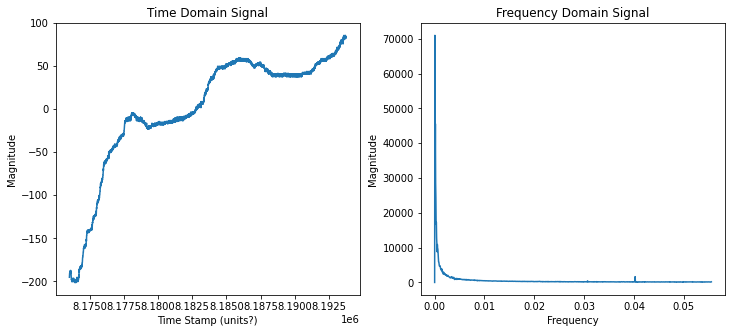

In [ ]:
# work with an example file
filename = patientFiles[8]

risingIndex, fallingIndex, df = mainSignalThreshold(filename, is_static = False)
t = df[5][risingIndex:fallingIndex]

pressure = df[3][risingIndex:fallingIndex]
pressure = pressure - np.mean(pressure)

# time step
N = len(t)
dt = t[risingIndex+1] - t[risingIndex]

# fourier transform
f = np.abs(np.fft.fft(pressure))

# which frequencies does the above output correspond to?
freqs = np.fft.fftfreq(N, dt)

# plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(t, pressure)
plt.title('Time Domain Signal')
plt.xlabel('Time Stamp (units?)')
plt.ylabel('Magnitude')

plt.subplot(1, 2, 2)
plt.plot(freqs[0:N//2], f[0:N//2])
#plt.ylim([0, 10000])
plt.title('Frequency Domain Signal')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')

plt.show()

Text(0.5, 1.0, 'Relative amount of bandpass-filtered content')

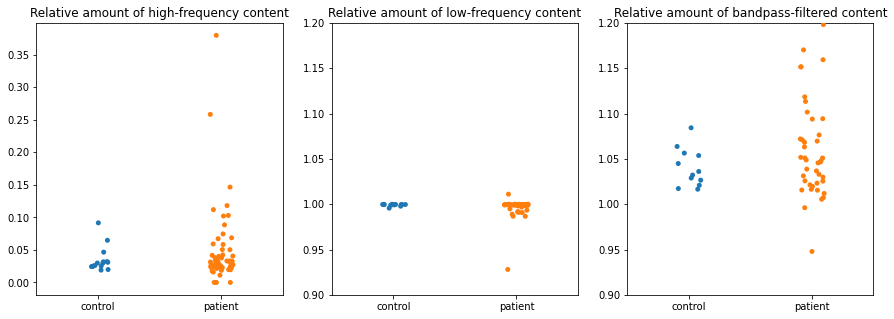

In [ ]:
cutoff = 0.12
high_frequency_metric = []
low_frequency_metric = []
bandpass_frequency_metric = []
is_static = False
for filename in controlFiles + patientFiles:
    df = pd.read_csv(filename, sep = ";", header = None)

    no_statics = True
    no_dynamics = True

    for i in list(df[6]):
        if i == 0:
            no_statics = False
        if i == 1:
            no_dynamics = False
        if no_statics == False and is_static == True:
            break
        if no_dynamics == False and is_static == False:
            break

    if no_statics == True and is_static == True:
        high_frequency_metric.append(0)
        low_frequency_metric.append(0)
        bandpass_frequency_metric.append(0);
        continue
    if no_dynamics == True and is_static == False:
        high_frequency_metric.append(0)
        low_frequency_metric.append(0)
        bandpass_frequency_metric.append(0);
        continue
        
    risingIndex, fallingIndex, df = mainSignalThreshold(filename, is_static)
    t = df[2][risingIndex:fallingIndex]
    pressure = df[3][risingIndex:fallingIndex]
    pressure = pressure - np.mean(pressure)

    # time step
    #dt = t[risingIndex+1] - t[risingIndex]
    dt = 1/60

    # apply lowpass filter
    pressure_lowpass_filtered = butter_lowpass_filter(pressure, cutoff, 1/dt)
    pressure_highpass_filtered = butter_highpass_filter(pressure, cutoff, 1/dt)
    pressure_bandpass_filtered = butter_bandpass_filter(pressure, 0.25, 0.6, 1/dt)

    # calculate?
    high_frequency_metric.append(np.linalg.norm(pressure_lowpass_filtered - pressure)/np.linalg.norm(pressure))
    low_frequency_metric.append(np.linalg.norm(pressure_highpass_filtered - pressure)/np.linalg.norm(pressure))
    bandpass_frequency_metric.append(np.linalg.norm(pressure_bandpass_filtered - pressure)/np.linalg.norm(pressure))

labels = ['control'] * len(controlFiles) + ['patient'] * len(patientFiles)

plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
sns.stripplot(x = labels, y = high_frequency_metric)
plt.title('Relative amount of high-frequency content')
plt.subplot(1, 3, 2)
sns.stripplot(x = labels, y = low_frequency_metric)
plt.ylim(0.9,1.2)
plt.title('Relative amount of low-frequency content')
plt.subplot(1, 3, 3)
sns.stripplot(x = labels, y = bandpass_frequency_metric)
plt.ylim(0.9,1.2)
plt.title('Relative amount of bandpass-filtered content')

In [ ]:
print(len(low_frequency_metric))
print(len(high_frequency_metric))
print(len(bandpass_frequency_metric))
bandpass_frequency_metric # we're getting ridiculously large values here
#low_frequency_metric
#high_frequency_metric

76
76
72


[1.0001398787695222,
 1.0001331005438978,
 1.0001202224295682,
 1.0000703571775975,
 1.0001849137871586,
 1.0002250803271266,
 1.0001852174311419,
 1.0000442217730556,
 1.0001397276066732,
 1.0000572060813568,
 1.0001969645823452,
 1.0001809741956724,
 1.0001343405600398,
 1.0001271195234194,
 1.0000664616021193,
 1.0003617019472233,
 1.0005846295788534,
 1.0001145302101393,
 1.0001185465788327,
 1.0001002461260582,
 1.0002829765520536,
 1.0003174940065263,
 1.0001490192258728,
 1.0001252356367312,
 1.0002782999743747,
 1.0000650200479644,
 1.0002944852515627,
 1.0000106033583276,
 1.0002795978917967,
 1.0002300579449799,
 1.0000028144425628,
 1.000084774506685,
 1.0003260010785051,
 1.0000992402767503,
 1.000513061004461,
 1.0005231151168201,
 1.0000677340169193,
 1.0195415242400516,
 1.0002216023687454,
 1.000186559616835,
 1.0002331995423899,
 1.0006095926745922,
 1.0001463028867739,
 1.0002307488432578,
 1.0001161397855416,
 1.0001339151290645,
 1.0002518604586363,
 1.0000825978669

## Fourier Transform Angle

Text(0.5, 1.0, 'Relative amount of bandpass-filtered content')

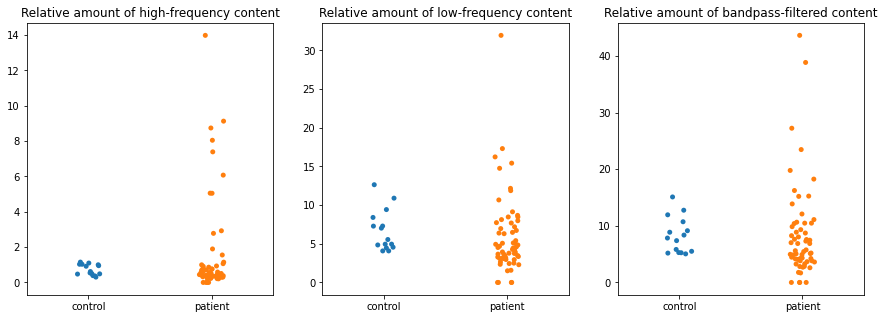

In [ ]:
cutoff = 0.12
high_frequency_metric = []
low_frequency_metric = []
bandpass_frequency_metric = []
is_static = False
for filename in controlFiles + patientFiles:
    df = pd.read_csv(filename, sep = ";", header = None)

    no_statics = True
    no_dynamics = True

    for i in list(df[6]):
        if i == 0:
            no_statics = False
        if i == 1:
            no_dynamics = False
        if no_statics == False and is_static == True:
            break
        if no_dynamics == False and is_static == False:
            break

    if no_statics == True and is_static == True:
        high_frequency_metric.append(0)
        low_frequency_metric.append(0)
        bandpass_frequency_metric.append(0)
        continue
    if no_dynamics == True and is_static == False:
        high_frequency_metric.append(0)
        low_frequency_metric.append(0)
        bandpass_frequency_metric.append(0)
        continue
        
    #risingIndex, fallingIndex, df = mainSignalThreshold(filename, is_static)

    t = df[2]
    angle = df[4]
    angle = angle - np.mean(angle)

    # time step
    #dt = t[risingIndex+1] - t[risingIndex]
    dt = 1/60

    # apply lowpass filter
    angle_lowpass_filtered = butter_lowpass_filter(angle, cutoff, 1/dt)
    angle_highpass_filtered = butter_highpass_filter(angle, cutoff, 1/dt)
    angle_bandpass_filtered = butter_bandpass_filter(angle, 0.25, 0.6, 1/dt) #.25-6

    # calculate?
    high_frequency_metric.append(np.linalg.norm(angle_lowpass_filtered - angle)/np.linalg.norm(pressure))
    low_frequency_metric.append(np.linalg.norm(angle_highpass_filtered - angle)/np.linalg.norm(pressure))
    bandpass_frequency_metric.append((np.linalg.norm(angle_bandpass_filtered - angle)/np.linalg.norm(pressure)))

labels = ['control'] * len(controlFiles) + ['patient'] * len(patientFiles)

plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
sns.stripplot(x = labels, y = high_frequency_metric)
plt.title('Relative amount of high-frequency content')
plt.subplot(1, 3, 2)
sns.stripplot(x = labels, y = low_frequency_metric)
plt.title('Relative amount of low-frequency content')
plt.subplot(1, 3, 3)
sns.stripplot(x = labels, y = bandpass_frequency_metric)
plt.title('Relative amount of bandpass-filtered content')

## High/low frequency feature calculation


In [ ]:
# returns low frequency, high frequency
def fourierFreqCalc(data, time): # time is df[5]
    cutoff = 0.12
    high_frequency_metric = []
    low_frequency_metric = []
    data = data - np.mean(data)

    # time step
    N = len(time)
    dt = time[1] - time[0]

    # apply lowpass filter
    data_lowpass_filtered = butter_lowpass_filter(data, cutoff, dt)
    data_highpass_filtered = butter_highpass_filter(data, cutoff, dt)

    # calculate
    high_frequency_metric = np.linalg.norm((data_lowpass_filtered - data)/np.linalg.norm(data))
    low_frequency_metric = np.linalg.norm((data_highpass_filtered - data)/np.linalg.norm(data))

    return low_frequency_metric, high_frequency_metric

## Split Static & Dynamic Drawings

In [ ]:
def staticDynamicSplit(df): 
    if 0 in df[6].unique(): 
        static_df = df[df[6]==0]
    else: 
        static_df = pd.DataFrame()

    if 1 in df[6].unique(): 
        dynamic_df = df[df[6]==1].reset_index()
    else: 
        dynamic_df = pd.DataFrame()

    return static_df, dynamic_df

## Entropy

In [ ]:
from sklearn.neighbors import KernelDensity
import math

def entropyCalc(data): 
    kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(data[:, None])
    logprob = kde.score_samples(data[:, None])
    prob = np.exp(logprob)

    entropy = -1 * sum([i * math.log(i, 2.0) for i in prob])
    return entropy

## Skewness & Kurtosis

In [ ]:
from scipy.stats import skew
from scipy.stats import kurtosis

# just call these "skew" & "kurtosis" functions on the data (where data is just an np array)

## Entropy, Skewness & Kurtosis Sample Calculation/Visualization

In [ ]:
x_static_entropy = []
y_static_entropy = []
x_dynamic_entropy = []
y_dynamic_entropy = []
x_static_skewness = []
y_static_skewness = []
x_dynamic_skewness = []
y_dynamic_skewness = []
x_static_kurtosis = []
y_static_kurtosis = []
x_dynamic_kurtosis = []
y_dynamic_kurtosis = []
static_category = []
dynamic_category = []

for filename in controlFiles: 
    df = pd.read_csv(filename, sep = ';', header = None)
    static_df, dynamic_df = staticDynamicSplit(df)
    static_x = np.array(static_df[static_df[3]!=0][0])
    static_y = np.array(static_df[static_df[3]!=0][1])
    dynamic_x = np.array(dynamic_df[dynamic_df[3]!=0][0])
    dynamic_y = np.array(dynamic_df[dynamic_df[3]!=0][1])

    if len(static_x) > 0: 
        x_static_entropy.append(entropyCalc(static_x))
        y_static_entropy.append(entropyCalc(static_y))
        x_static_skewness.append(skew(static_x))
        y_static_skewness.append(skew(static_y))
        x_static_kurtosis.append(kurtosis(static_x))
        y_static_kurtosis.append(kurtosis(static_y))
        static_category.append("Static Control")

    if len(dynamic_x) > 0: 
        x_dynamic_entropy.append(entropyCalc(dynamic_x))
        y_dynamic_entropy.append(entropyCalc(dynamic_y))
        x_dynamic_skewness.append(skew(dynamic_x))
        y_dynamic_skewness.append(skew(dynamic_y))
        x_dynamic_kurtosis.append(kurtosis(dynamic_y))
        y_dynamic_kurtosis.append(kurtosis(dynamic_y))
        dynamic_category.append("Dynamic Control")

for filename in patientFiles: 
    df = pd.read_csv(filename, sep = ';', header = None)
    static_df, dynamic_df = staticDynamicSplit(df)
    static_x = np.array(static_df[static_df[3]!=0][0])
    static_y = np.array(static_df[static_df[3]!=0][1])
    dynamic_x = np.array(dynamic_df[dynamic_df[3]!=0][0])
    dynamic_y = np.array(dynamic_df[dynamic_df[3]!=0][1])

    if len(static_x) > 0: 
        x_static_entropy.append(entropyCalc(static_x))
        y_static_entropy.append(entropyCalc(static_y))
        x_static_skewness.append(skew(static_x))
        y_static_skewness.append(skew(static_y))
        x_static_kurtosis.append(kurtosis(static_x))
        y_static_kurtosis.append(kurtosis(static_y))
        static_category.append("Static Patient")

    if len(dynamic_x) > 0: 
        x_dynamic_entropy.append(entropyCalc(dynamic_x))
        y_dynamic_entropy.append(entropyCalc(dynamic_y))
        x_dynamic_skewness.append(skew(dynamic_x))
        y_dynamic_skewness.append(skew(dynamic_y))
        x_dynamic_kurtosis.append(kurtosis(dynamic_y))
        y_dynamic_kurtosis.append(kurtosis(dynamic_y))
        dynamic_category.append("Dynamic Patient")

KeyError: 3

In [ ]:
plt.figure(1)
plt.subplots(2, 3, 1)
sns.stripplot(x = xvalue, y = x_static_entropy)
plt.subplots(2, 3, 2)
sns.stripplot(x = xvalue, y = y_static_entropy)
plt.subplots(2, 3, 3)
sns.stripplot(x = xvalue, y = )

In [ ]:
from sklearn.neighbors import KernelDensity
import math

def xentropyCalc(csv_path, static):
    df = pd.read_csv(csv_path, sep = ';', header = None)

    if static == True: 
        print("static evaluated to true")
        if 0 in df[6].unique(): 
            df = df[(df[6]==0)]
            x = np.array(df[df[3]!=0][0])
            y = np.array(df[df[3]!=0][1])
            print("df[6] has 0s")
        else: 
            print("we're in the else statement")
            return np.nan
    else: 
        if 1 in df[6].unique(): 
            df = df[(df[6]==1)]
            x = np.array(df[df[3]!=0][0])
            y = np.array(df[df[3]!=0][1])
        else: 
            print("we're in the else statement")
            return np.nan

    print(csv_path)
    kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(x[:, None])
    logxprob = kde.score_samples(x[:, None])
    xprob = np.exp(logxprob)

    xentropy = -1 * sum([i * math.log(i, 2.0) for i in xprob])
    return xentropy

def yentropyCalc(csv_path, static):
    df = pd.read_csv(csv_path, sep = ';', header = None)

    if static == True: 
        print("static evaluated to true")
        if 0 in df[6].unique(): 
            df = df[(df[6]==0)]
            x = np.array(df[df[3]!=0][0])
            y = np.array(df[df[3]!=0][1])
            print("df[6] has 0s")
        else: 
            print("we're in the else statement")
            return np.nan
    else: 
        if 1 in df[6].unique(): 
            df = df[(df[6]==1)]
            x = np.array(df[df[3]!=0][0])
            y = np.array(df[df[3]!=0][1])
        else: 
            print("we're in the else statement")
            return np.nan

    print(csv_path)

    kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(y[:, None])
    logyprob = kde.score_samples(y[:, None])
    yprob = np.exp(logyprob)

    yentropy = -1 * sum([i * math.log(i, 2.0) for i in yprob])
    return yentropy

### Static Drawings Entropy

In [ ]:
xentropyStatic = []
yentropyStatic = []
patientState = []
for filename in controlFiles: 
    xentropy = xentropyCalc(filename, True)
    yentropy = yentropyCalc(filename, True)
    if xentropy != np.nan: 
        xentropyStatic.append(xentropy)
    if yentropy != np.nan: 
        yentropyStatic.append(yentropy)
    patientState.append("Control")
for filename in patientFiles: 
    xentropy = xentropyCalc(filename, True)
    yentropy = yentropyCalc(filename, True)
    if xentropy != np.nan: 
        xentropyStatic.append(xentropy)
    if yentropy != np.nan: 
        yentropyStatic.append(yentropy)
    patientState.append("Patient")

NameError: name 'xentropyCalc' is not defined

<AxesSubplot:title={'center':'Entropy Y Coordinate'}>

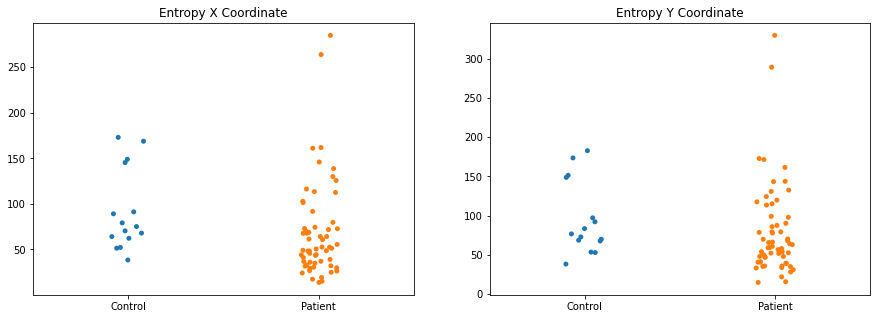

In [ ]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.title("Entropy X Coordinate")
sns.stripplot(x = patientState, y = xentropyStatic)
plt.subplot(1, 2, 2)
plt.title("Entropy Y Coordinate")
sns.stripplot(x = patientState, y = yentropyStatic)

### Dynamic Entropy

In [ ]:
xentropyDynamic = []
yentropyDynamic = []
patientState = []
for filename in controlFiles: 
    xentropy = xentropyCalc(filename, False)
    yentropy = yentropyCalc(filename, False)
    if xentropy != np.nan: 
        xentropyDynamic.append(xentropy)
    if yentropy != np.nan: 
        yentropyDynamic.append(yentropy)
    patientState.append("Control")
for filename in patientFiles: 
    xentropy = xentropyCalc(filename, False)
    yentropy = yentropyCalc(filename, False)
    if xentropy != np.nan: 
        xentropyDynamic.append(xentropy)
    if yentropy != np.nan: 
        yentropyDynamic.append(yentropy)
    patientState.append("Patient")

/work/ParkinsonHW/C_0001.txt
/work/ParkinsonHW/C_0001.txt
/work/ParkinsonHW/C_0002.txt
/work/ParkinsonHW/C_0002.txt
/work/ParkinsonHW/C_0003.txt
/work/ParkinsonHW/C_0003.txt
/work/ParkinsonHW/C_0004.txt
/work/ParkinsonHW/C_0004.txt
/work/ParkinsonHW/C_0005.txt
/work/ParkinsonHW/C_0005.txt
/work/ParkinsonHW/C_0006.txt
/work/ParkinsonHW/C_0006.txt
/work/ParkinsonHW/C_0007.txt
/work/ParkinsonHW/C_0007.txt
/work/ParkinsonHW/C_0008.txt
/work/ParkinsonHW/C_0008.txt
/work/ParkinsonHW/C_0009.txt
/work/ParkinsonHW/C_0009.txt
/work/ParkinsonHW/C_0010.txt
/work/ParkinsonHW/C_0010.txt
/work/ParkinsonHW/C_0011.txt
/work/ParkinsonHW/C_0011.txt
/work/ParkinsonHW/C_0012.txt
/work/ParkinsonHW/C_0012.txt
/work/ParkinsonHW/C_0013.txt
/work/ParkinsonHW/C_0013.txt
/work/ParkinsonHW/C_0014.txt
/work/ParkinsonHW/C_0014.txt
/work/ParkinsonHW/C_0015.txt
/work/ParkinsonHW/C_0015.txt
/work/ParkinsonHW/H_P000-0003.txt
/work/ParkinsonHW/H_P000-0003.txt
/work/ParkinsonHW/H_P000-0004.txt
/work/ParkinsonHW/H_P000-000

<AxesSubplot:title={'center':'Entropy Y Coordinate Dynamic'}>

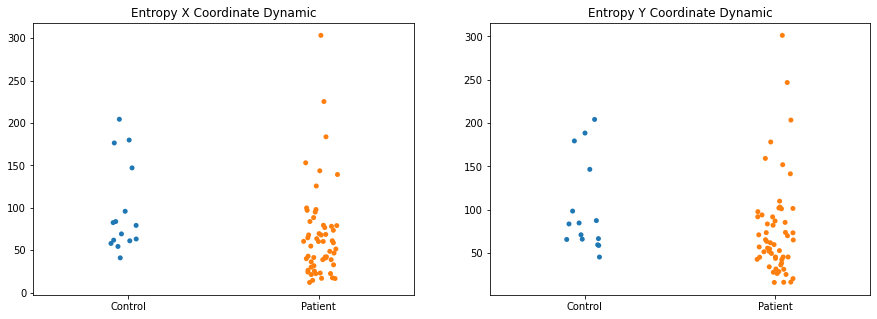

In [ ]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.title("Entropy X Coordinate Dynamic")
sns.stripplot(x = patientState, y = xentropyDynamic)
plt.subplot(1, 2, 2)
plt.title("Entropy Y Coordinate Dynamic")
sns.stripplot(x = patientState, y = yentropyDynamic)

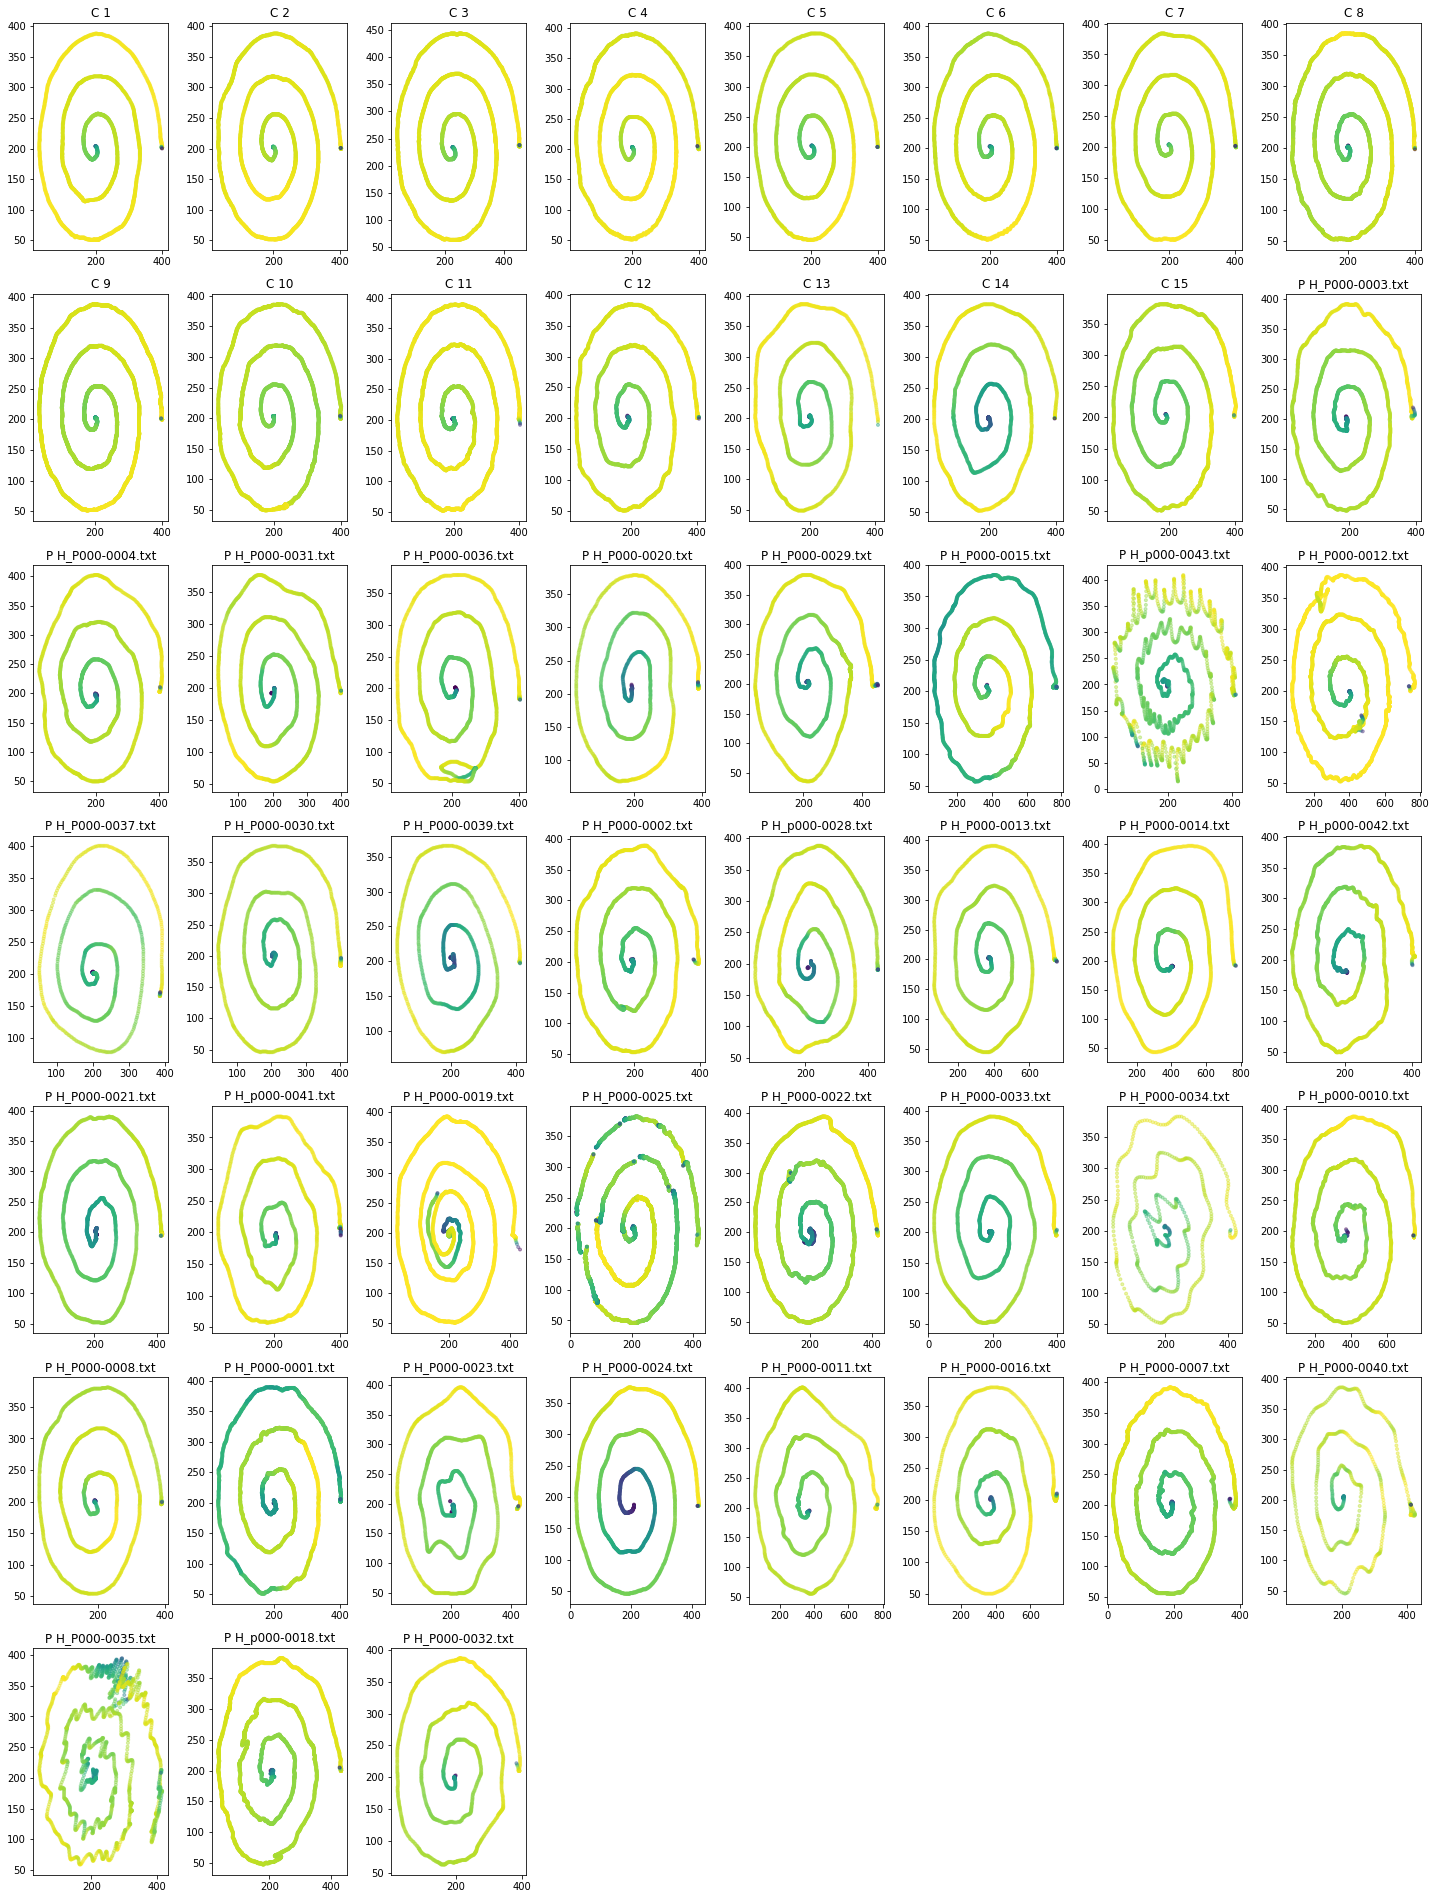

In [ ]:
# Run smoothfunc first on the truncated data and then
#Pressure plots
#0    	X coordinate
#1    	Y coordinate
#2    	
#3    	pressure
#4    	
#5    	timestamp
#6    	control/patient

#Controls
count = 0
plt.figure(figsize = (20, 30), tight_layout = True)
for i in range(1, 16): 
    if i < 10: 
        df = pd.read_csv('/work/ParkinsonHW/C_000' + str(i) + '.txt', sep = ';', header = None)
    else: 
        df = pd.read_csv('/work/ParkinsonHW/C_00' + str(i) + '.txt', sep = ';', header = None)
    df_static = df[(df[6] == 0)]
    count += 1
    plt.subplot(8, 8, count)
    plt.scatter(df_static[0], df_static[1], c = df_static[3], alpha = 0.4, marker = '.')
    plt.title("C " + str(i))

#Patients
directory = os.fsencode('/work/ParkinsonHW')
for file in os.listdir(directory): 
    filename = os.fsdecode(file)
    if filename[0] ==  'H' and int(filename[9:11]) <= 43:
    #if filename[0] == 'P' or filename[0] == 'H': 
        path = os.path.join('/work/ParkinsonHW', filename)
        df = pd.read_csv(path, sep = ';', header = None)
        
        if 0 not in list(df[6]):
            continue
        df_static = df[(df[6]==0)]
        count += 1
        plt.subplot(8, 8, count)
        plt.scatter(df_static[0], df_static[1], c = df_static[3], alpha = 0.4, marker = '.')
        plt.title("P " + str(filename))

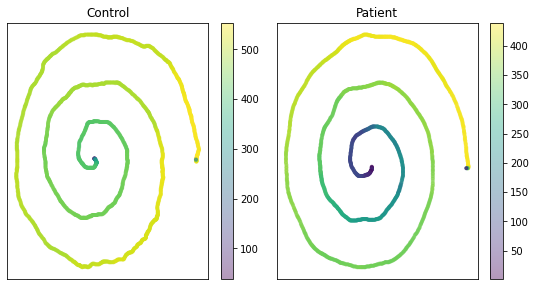

In [ ]:
plt.figure(figsize = (30, 30), tight_layout = True)
path = ('/work/ParkinsonHW/C_0015.txt')
df = pd.read_csv(path, sep = ';', header = None)
df_static = df[(df[6]==0)]
plt.subplot(8, 8, 1)
plt.scatter(df_static[0], df_static[1], c = df_static[3], alpha = 0.4, marker = '.')
plt.title('Control')
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
plt.colorbar()
path = ('/work/ParkinsonHW/H_P000-0024.txt')
df = pd.read_csv(path, sep = ';', header = None)
df_static = df[(df[6]==0)]
plt.subplot(8, 8, 2)
plt.scatter(df_static[0], df_static[1], c = df_static[3], alpha = 0.4, marker = '.')
plt.title('Patient')
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
plt.colorbar()
plt.show()

## Rising edge, main signal, falling edge durations & Range

In [ ]:
# rising edge & falling edge durations
def risingFallingFeatures(csv_file, is_static = True): 
    risingIndex, fallingIndex, df = mainSignalThreshold(csv_file, is_static)

    rising_duration = df[5][risingIndex] - df[5][0]
    falling_duration = df[5][len(df[5])-1] - df[5][fallingIndex]

    rising_range = df[3][risingIndex] - df[3][0]
    falling_range = df[3][fallingIndex] - df[3][len(df[5])-1]

    return rising_duration, falling_duration, rising_range, falling_range

### Static drawings

Text(0.5, 1.0, 'Falling Range Comparison')

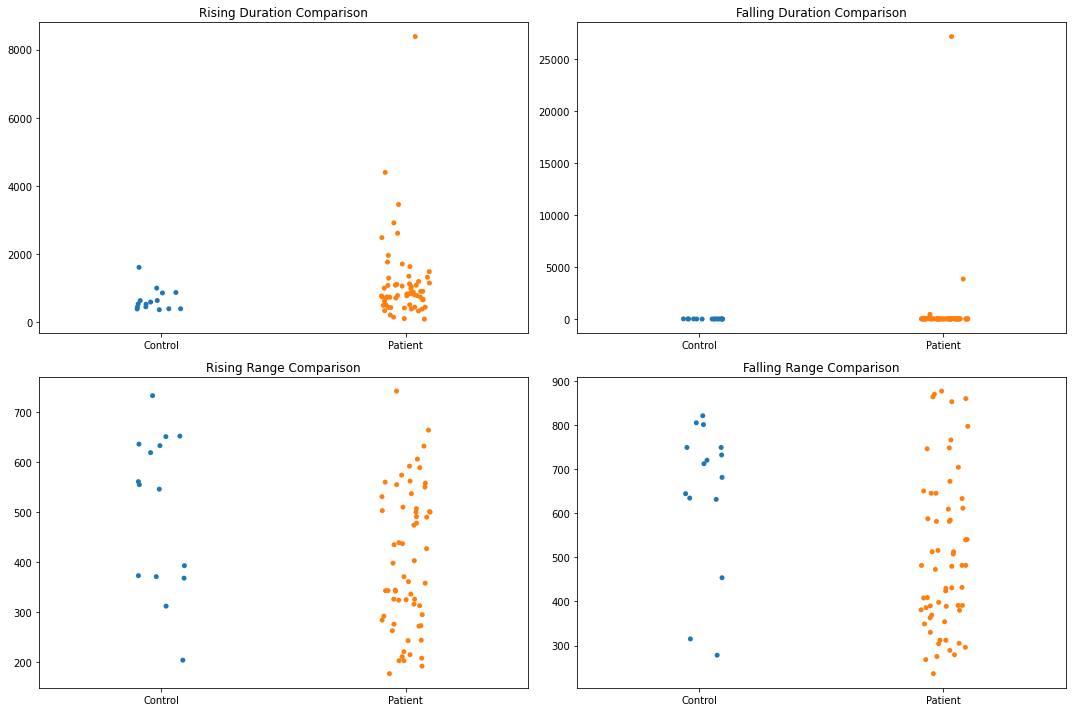

In [ ]:
rising_time = []
falling_time = []
risingRange = []
fallingRange = []
xvalue = []
for filename in controlFiles:
    rising_time.append(risingFallingFeatures(filename)[0])
    falling_time.append(risingFallingFeatures(filename)[1])
    risingRange.append(risingFallingFeatures(filename)[2])
    fallingRange.append(risingFallingFeatures(filename)[3])
    xvalue.append('Control')
for filename in patientFiles: 
    rising_time.append(risingFallingFeatures(filename)[0])
    falling_time.append(risingFallingFeatures(filename)[1])
    risingRange.append(risingFallingFeatures(filename)[2])
    fallingRange.append(risingFallingFeatures(filename)[3])
    xvalue.append('Patient')
plt.figure(figsize = (15, 10), tight_layout = True)
plt.subplot(2, 2, 1)
sns.stripplot(x = xvalue, y = rising_time)
plt.title('Rising Duration Comparison')
plt.subplot(2, 2, 2)
sns.stripplot(x = xvalue, y = falling_time)
plt.title('Falling Duration Comparison')
plt.subplot(2, 2, 3)
sns.stripplot(x = xvalue, y = risingRange)
plt.title('Rising Range Comparison')
plt.subplot(2, 2, 4)
sns.stripplot(x = xvalue, y = fallingRange)
plt.title('Falling Range Comparison')

### Dynamic Drawings

In [ ]:
rising_time = []
falling_time = []
risingRange = []
fallingRange = []
xvalue = []
for filename in controlFiles:
    rising_time.append(risingFallingFeatures(filename, False)[0])
    falling_time.append(risingFallingFeatures(filename, False)[1])
    risingRange.append(risingFallingFeatures(filename, False)[2])
    fallingRange.append(risingFallingFeatures(filename, False)[3])
    xvalue.append('Control')
for filename in patientFiles: 
    rising_time.append(risingFallingFeatures(filename, False)[0])
    falling_time.append(risingFallingFeatures(filename, False)[1])
    risingRange.append(risingFallingFeatures(filename, False)[2])
    fallingRange.append(risingFallingFeatures(filename, False)[3])
    xvalue.append('Patient')
plt.figure(figsize = (15, 10), tight_layout = True)
plt.subplot(2, 2, 1)
sns.stripplot(x = xvalue, y = rising_time)
plt.title('Rising Duration Comparison')
plt.subplot(2, 2, 2)
sns.stripplot(x = xvalue, y = falling_time)
plt.title('Falling Duration Comparison')
plt.subplot(2, 2, 3)
sns.stripplot(x = xvalue, y = risingRange)
plt.title('Rising Range Comparison')
plt.subplot(2, 2, 4)
sns.stripplot(x = xvalue, y = fallingRange)
plt.title('Falling Range Comparison')

KeyError: 0

## Pressure, Curvature & Velocity Regression

In [ ]:
import statsmodels.api as sm
# no smoothing at all, only raw pressure
def press_reg(csv_path, mainS, static):
    df = pd.read_csv(csv_path, sep = ';', header = None)
    if 1 in df[6].unique():
        risingIndex, fallingIndex, df = mainSignalThreshold(filename, static)
        pressure = df[3]
        if mainS == 0:
            pressure = pressure[risingIndex:fallingIndex]
        elif mainS == 1:
            pressure = pressure[0: risingIndex]
        else:
            pressure = pressure[fallingIndex:]
        print(filename)
        print (risingIndex, fallingIndex, len(df[3]))
        model = sm.OLS(pressure, sm.add_constant(np.array(range(len(pressure)))))
        results = model.fit()
        return [results.rsquared, results.params[0], results.params[1], sum(abs(results.resid))]
    else:
        return [0, 0, 0, 0]


def curve_reg(csv_path, static):
    df = pd.read_csv(csv_path, sep = ';', header = None)
    if 0 in df[6].unique():
        df_static = df[(df[6]==0)]
        x = df_static[0]
        y = df_static[1]
        curve = np.array([x, y])
        smoothing_factor = 100000
        _, _, _, curvature, _ = smoothCurveFeature(curve, 1000, smoothing_factor, df_static)
        curvature = curvature[50: len(curvature)-100]
        model = sm.OLS(curvature, sm.add_constant(np.array(range(len(curvature)))))
        results = model.fit()
        return [results.rsquared, results.params[0], results.params[1], sum(abs(results.resid))]
    else:
        return [0, 0, 0, 0]


def func_log (x, a, b):
    return a+b*np.log(x)

def func_inv (x, a, b):
    return a + (b/(x + 10**-10))

def curve_reg_log(csv_path, static):
    df = pd.read_csv(csv_path, sep = ';', header = None)
    if 0 in df[6].unique():
        df_static = df[(df[6]==0)]
        x = df_static[0]
        y = df_static[1]
        curve = np.array([x, y])
        smoothing_factor = 100000
        _, _, _, curvature, _ = smoothCurveFeature(curve, 1000, smoothing_factor, df_static)
        curvature = curvature[100: len(curvature)-100]
        xdata = np.array(range(len(curvature))) + 1
        param, cov  = scipy.optimize.curve_fit(func_inv, xdata, curvature)
        residuals = curvature - func_inv(xdata, *param)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((curvature-np.mean(curvature))**2)
        r_squared = 1 - (ss_res / ss_tot)
        return [r_squared, param[0], param[1], ss_res]
    else:
        return [0, 0, 0, 0]

def vel_reg(csv_path, static):
    df = pd.read_csv(csv_path, sep = ';', header = None)
    if 1 in df[6].unique():
        df_static = df[(df[6]==1)]
        x = df_static[0]
        y = df_static[1]
        curve = np.array([x, y])
        smoothing_factor = 10000
        velocity, _, _, _, _ = smoothCurveFeature(curve, n, smoothing_factor, df_static)
        velocity = velocity[75: len(velocity)-75]
        model = sm.OLS(velocity, sm.add_constant(np.array(range(len(velocity)))))
        results = model.fit()
        return [results.rsquared, results.params[0], results.params[1], sum(abs(results.resid))]
    else:
        return [0, 0, 0, 0]

In [ ]:
n = 1000
patientState = []
rsquaredV = []
coeff0V = []
coeff1V = []
residsV = []

for filename in controlFiles: 
    final = vel_reg(filename, True)
    rsquaredV.append(final[0])
    coeff0V.append(final[1])
    coeff1V.append(final[2])
    residsV.append(final[3])
    patientState.append("Control")

for filename in patientFiles:
    final = vel_reg(filename, True)
    rsquaredV.append(final[0])
    coeff0V.append(final[1])
    coeff1V.append(final[2])
    residsV.append(final[3])
    patientState.append("Patient")

Text(0.5, 1.0, 'Sum of Residuals for Velocity Regression')

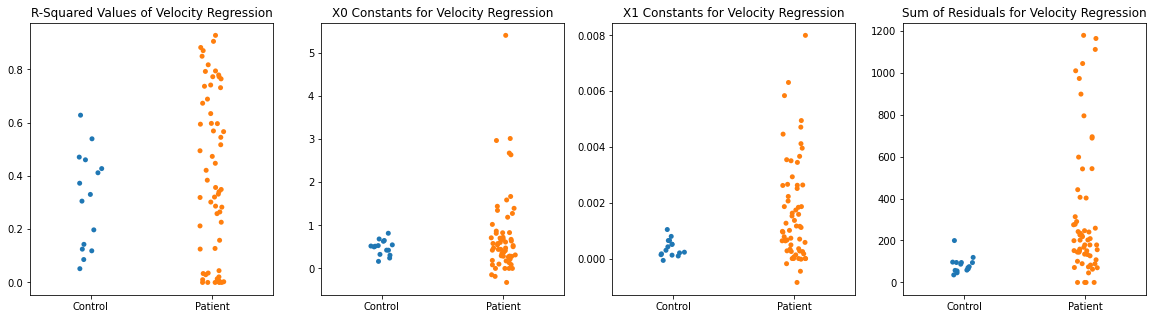

In [ ]:
# Velocity Regression
plt.figure(figsize = (20, 5))
plt.subplot(1, 4, 1)
sns.stripplot(x = patientState, y = rsquaredV)
plt.title('R-Squared Values of Velocity Regression')
plt.subplot(1, 4, 2)
sns.stripplot(x = patientState, y = coeff0V)
plt.title('X0 Constants for Velocity Regression')
plt.subplot(1, 4, 3)
sns.stripplot(x = patientState, y = coeff1V)
plt.title('X1 Constants for Velocity Regression')
plt.subplot(1, 4, 4)
sns.stripplot(x = patientState, y = residsV)
plt.title('Sum of Residuals for Velocity Regression')

In [ ]:
patientState = []
rsquaredP = []
coeff0P = []
coeff1P = []
residsP = []

for filename in controlFiles: 
    final = press_reg(filename, 0, False)
    rsquaredP.append(final[0])
    coeff0P.append(final[1])
    coeff1P.append(final[2])
    residsP.append(final[3])
    patientState.append("Control")

for filename in patientFiles:
    final = press_reg(filename, 0, False)
    rsquaredP.append(final[0])
    coeff0P.append(final[1])
    coeff1P.append(final[2])
    residsP.append(final[3])
    patientState.append("Patient")

/work/ParkinsonHW/C_0001.txt
100 3214 3222
/work/ParkinsonHW/C_0002.txt
65 3322 3330
/work/ParkinsonHW/C_0003.txt
78 4050 4058
/work/ParkinsonHW/C_0004.txt
82 3085 3093
/work/ParkinsonHW/C_0005.txt
72 2215 2224
/work/ParkinsonHW/C_0006.txt
57 2376 2385
/work/ParkinsonHW/C_0007.txt
72 2585 2594
/work/ParkinsonHW/C_0008.txt
126 7641 7647
/work/ParkinsonHW/C_0009.txt
52 7356 7362
/work/ParkinsonHW/C_0010.txt
84 5350 5358
/work/ParkinsonHW/C_0011.txt
157 6616 6625
/work/ParkinsonHW/C_0012.txt
116 2364 2373
/work/ParkinsonHW/C_0013.txt
55 1559 1566
/work/ParkinsonHW/C_0014.txt
101 2013 2019
/work/ParkinsonHW/C_0015.txt
66 2510 2516
/work/ParkinsonHW/H_P000-0003.txt
122 1456 1465
/work/ParkinsonHW/H_P000-0004.txt
94 1812 1819
/work/ParkinsonHW/P_30100002.txt
44 3274 3282
/work/ParkinsonHW/P_09100001.txt
102 2904 2910
/work/ParkinsonHW/P_26060003.txt
186 1847 1853
/work/ParkinsonHW/H_P000-0031.txt
160 1304 1311
/work/ParkinsonHW/H_P000-0036.txt
110 1528 1537
/work/ParkinsonHW/H_P000-0020.txt


Text(0.5, 1.0, 'Sum of Residuals for Pressure Regression')

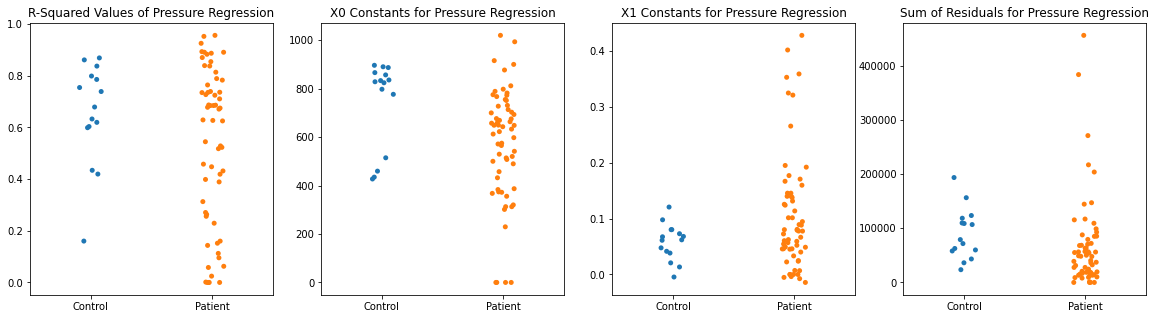

In [ ]:
# Pressure Regression Scatterplots (Don't show too much promise at the moment (other than x1 constant))
plt.figure(figsize = (20, 5))
plt.subplot(1, 4, 1)
sns.stripplot(x = patientState, y = rsquaredP)
plt.title('R-Squared Values of Pressure Regression')
plt.subplot(1, 4, 2)
sns.stripplot(x = patientState, y = coeff0P)
plt.title('X0 Constants for Pressure Regression')
plt.subplot(1, 4, 3)
sns.stripplot(x = patientState, y = coeff1P)
plt.title('X1 Constants for Pressure Regression')
plt.subplot(1, 4, 4)
sns.stripplot(x = patientState, y = residsP)
plt.title('Sum of Residuals for Pressure Regression')

In [ ]:
patientState = []
rsquaredC = []
coeff0C = []
coeff1C = []
residsC = []

for filename in controlFiles: 
    final = curve_reg(filename, True)
    rsquaredC.append(final[0])
    coeff0C.append(final[1])
    coeff1C.append(final[2])
    residsC.append(final[3])
    patientState.append("Control")

for filename in patientFiles:
    final = curve_reg(filename, True)
    rsquaredC.append(final[0])
    coeff0C.append(final[1])
    coeff1C.append(final[2])
    residsC.append(final[3])
    patientState.append("Patient")

Text(0.5, 1.0, 'Sum of Residuals for Curvature Regression')

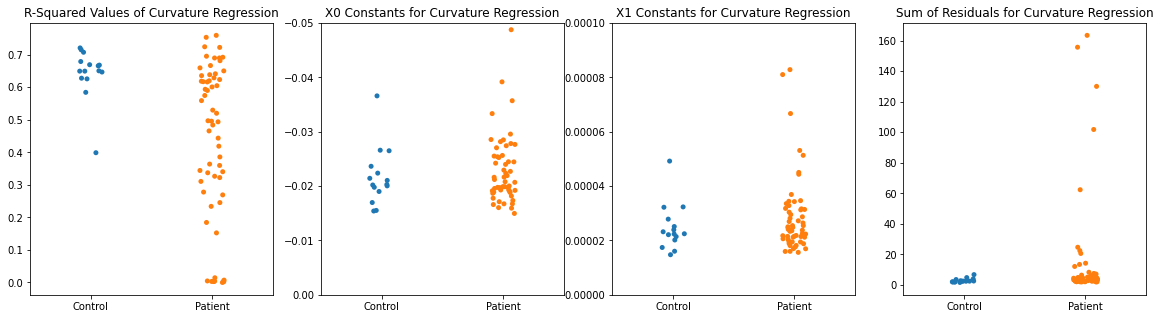

In [ ]:
# Pressure Regression Scatterplots (Don't show too much promise at the moment (other than x1 constant))
plt.figure(figsize = (20, 5))
plt.subplot(1, 4, 1)
sns.stripplot(x = patientState, y = rsquaredC)
plt.title('R-Squared Values of Curvature Regression')
plt.subplot(1, 4, 2)
plt.ylim(0, -0.05)
sns.stripplot(x = patientState, y = coeff0C)
plt.title('X0 Constants for Curvature Regression')
plt.subplot(1, 4, 3)
plt.ylim(0, 0.0001)
sns.stripplot(x = patientState, y = coeff1C)
plt.title('X1 Constants for Curvature Regression')
plt.subplot(1, 4, 4)
sns.stripplot(x = patientState, y = residsC)
plt.title('Sum of Residuals for Curvature Regression')

In [ ]:
patientStateL = []
rsquaredCL = []
coeff0CL = []
coeff1CL = []
residsCL = []

for filename in controlFiles: 
    final = curve_reg_log(filename, True)
    rsquaredCL.append(final[0])
    coeff0CL.append(final[1])
    coeff1CL.append(final[2])
    residsCL.append(final[3])
    patientStateL.append("Control")

for filename in patientFiles:
    final = curve_reg_log(filename, True)
    rsquaredCL.append(final[0])
    coeff0CL.append(final[1])
    coeff1CL.append(final[2])
    residsCL.append(final[3])
    patientStateL.append("Patient")

Text(0.5, 1.0, 'Sum of Residuals for Curvature Regression')

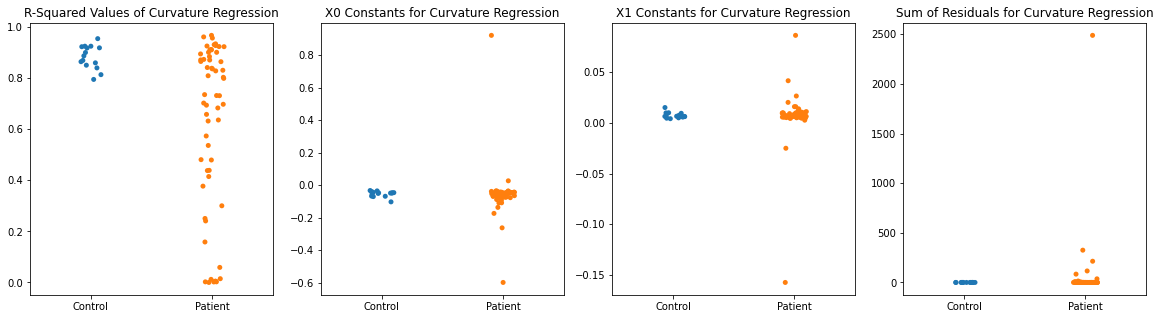

In [ ]:
# Pressure Regression Scatterplots (Don't show too much promise at the moment (other than x1 constant))
plt.figure(figsize = (20, 5))
plt.subplot(1, 4, 1)
sns.stripplot(x = patientStateL, y = rsquaredCL)
plt.title('R-Squared Values of Curvature Regression')
plt.subplot(1, 4, 2)
sns.stripplot(x = patientStateL, y = coeff0CL)
plt.title('X0 Constants for Curvature Regression')
plt.subplot(1, 4, 3)
sns.stripplot(x = patientStateL, y = coeff1CL)
plt.title('X1 Constants for Curvature Regression')
plt.subplot(1, 4, 4)
sns.stripplot(x = patientStateL, y = residsCL)
plt.title('Sum of Residuals for Curvature Regression')

In [ ]:
colors = []
for patient in patientState:
    if patient == 'Control':
        colors.append('r')
    else:
        colors.append('b')
plt.scatter(rsquaredCL, residsV, c = colors)
plt.xlabel('R^2 Curvature')
plt.ylabel('Velocity Sum of Residuals')
plt.show()

NameError: name 'patientState' is not defined

Text(0.5, 0, 'Velocity Sum of Residuals')

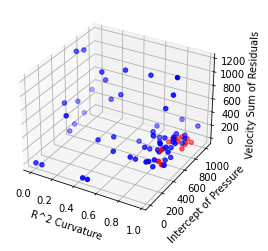

In [ ]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(rsquaredCL, coeff0P, residsV, c = colors);
ax.set_xlabel('R^2 Curvature')
ax.set_ylabel('Intercept of Pressure')
ax.set_zlabel('Velocity Sum of Residuals')

In [ ]:
features_df_static

Subject ID  Category  Mean Velocity  Velocity Std  Peak Velocity  \
0            C1         0       0.741703      0.213953       1.376681   
1            C2         0       0.561856      0.135978       1.030646   
2            C3         0       0.576393      0.123113       0.880655   
3            C4         0       0.614640      0.132637       1.006097   
4            C5         0       0.977548      0.294737       1.715694   
..          ...       ...            ...           ...            ...   
71   P_26060007         1       0.766879      0.394579       2.521991   
72  H_P000-0035         1       2.474440      2.008780      17.906847   
73  H_p000-0018         1       0.451769      0.166524       0.826703   
74   P_23100002         1       0.640608      0.179111       1.188470   
75  H_P000-0032         1       1.607949      0.405465       2.711710   

         NVV       NIV  Mean Acceleration  Acceleration Std  \
0   0.000600  0.000772           0.006822          0.004925   
1   0.000326  0.000449           0.003585          0.001899   
2   0.000291  0.000422           0.003696          0.002393   
3   0.000365  0.000518           0.004139          0.002284   
4   0.000417  0.000720           0.009541          0.004476   
..       ...       ...                ...               ...   
71  0.000655  0.000749           0.008158          0.006551   
72  0.019659  0.009140           0.692307          1.031537   
73  0.000952  0.000875           0.005636          0.005341   
74  0.000340  0.000514           0.004599          0.002638   
75  0.001939  0.002335           0.042407          0.022611   

    Peak Acceleration  ...  Jerk Std   Max Jerk       NIJ       NIC  Duration  \
0            0.034819  ...  0.000398   0.003017  0.001654  0.000937     18137   
1            0.014263  ...  0.000080   0.000622  0.001264  0.000693     24521   
2            0.019992  ...  0.000206   0.001958  0.001209  0.000591     35559   
3            0.016273  ...  0.000117   0.001339  0.001649  0.000848     21219   
4            0.032076  ...  0.000244   0.002570  0.002232  0.001152     13886   
..                ...  ...       ...        ...       ...       ...       ...   
71           0.048635  ...  0.000591   0.005485  0.001782  0.000962     28056   
72          12.584664  ...  0.932046  12.821862  0.011287  0.006440     14442   
73           0.039233  ...  0.000331   0.002511  0.002312  0.001094     32002   
74           0.012668  ...  0.000138   0.000829  0.001474  0.000754     29174   
75           0.111181  ...  0.003621   0.017648  0.005114  0.002779      8995   

    Mean Pressure  Median Pressure  Peak Pressure  Pressure Std  \
0      900.403990       906.619046     936.988374     32.218438   
1      797.728963       797.026365     827.263664     17.249718   
2      856.772596       855.861037     881.170685     14.345989   
3      908.361163       914.190886     930.836925     15.640649   
4      935.546798       937.903803    1012.068821     44.730827   
..            ...              ...            ...           ...   
71     433.666127       453.835593     496.439416     60.849578   
72     747.664064       768.484842     953.098470    110.298328   
73     676.000805       672.298528     747.880698     31.140068   
74     959.257873       971.041948    1009.106943     38.325740   
75     815.767035       810.287954     901.408976     48.747049   

    Rate of Inversion in Pressure  
0                        0.012792  
1                        0.009951  
2                        0.006806  
3                        0.011641  
4                        0.016059  
..                            ...  
71                       0.001711  
72                       0.010040  
73                       0.007562  
74                       0.007575  
75                       0.015787  

[76 rows x 22 columns]

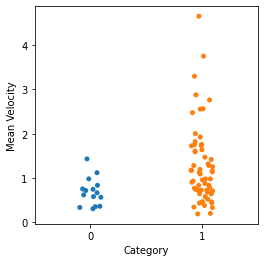

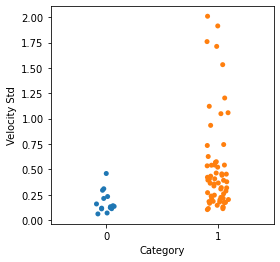

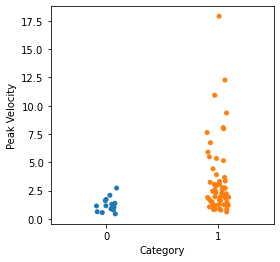

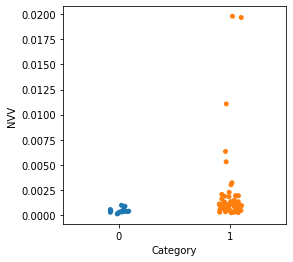

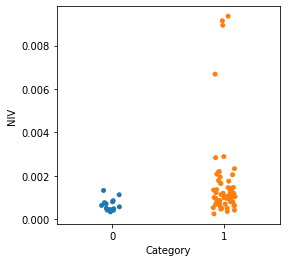

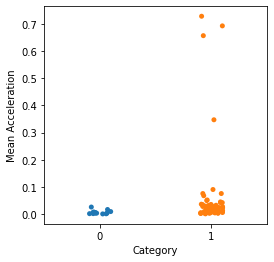

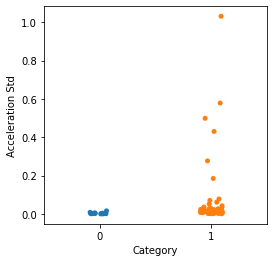

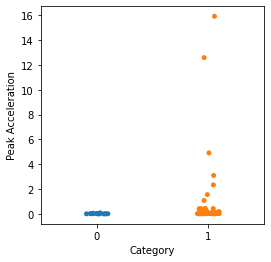

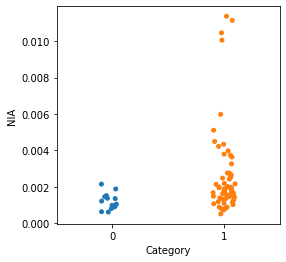

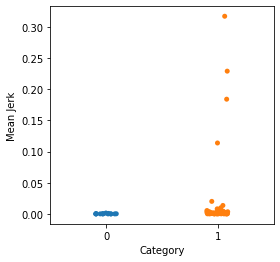

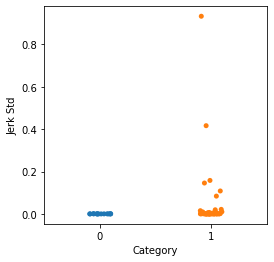

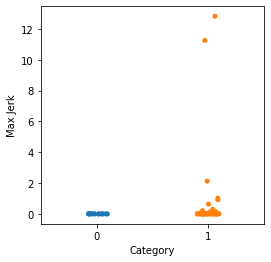

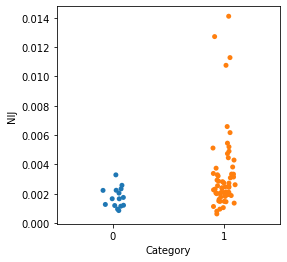

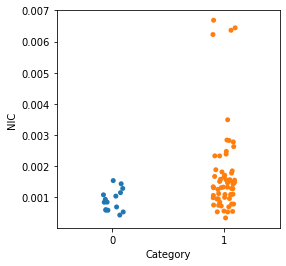

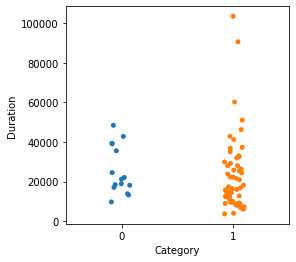

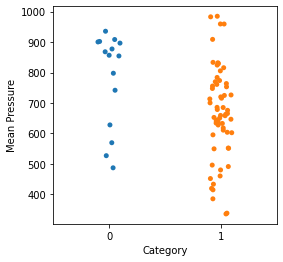

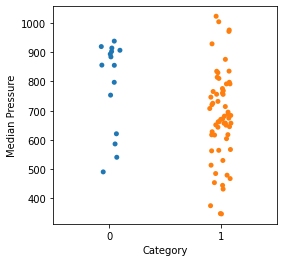

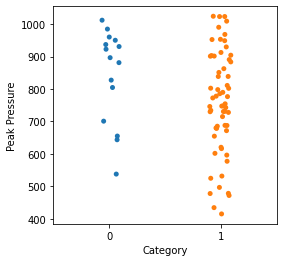

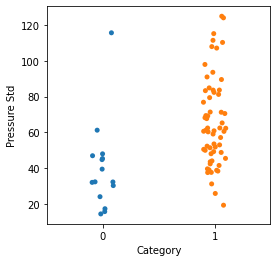

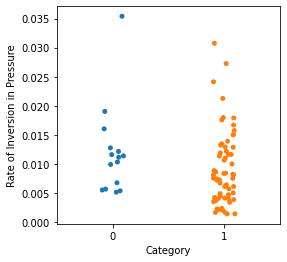

In [ ]:
for i in features_df_static.columns[2:]: 
    plt.figure(figsize = (4, 4))
    #plt.title('Strip Plot of {} vs. Category (0 - Control; 1 - Patient)'.format(i), fontsize = 15)
    sns.stripplot(x = features_df_static['Category'], y = features_df_static[i])

## Feature Selection

In [ ]:
# Not using this anymore
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

feature_cols = features_df_static.columns[2:].values
Xcols = features_df_static.loc[:, feature_cols]
ycols = features_df_static.Category

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=20)
fit = bestfeatures.fit(Xcols,ycols)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(Xcols.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(20,'Score'))  #print 20 best features

                            Specs        Score
14                       Duration  3867.019330
15                  Mean Pressure   236.989967
16                Median Pressure   207.197166
18                   Pressure Std   133.466463
17                  Peak Pressure   108.640345
2                   Peak Velocity    18.285192
7               Peak Acceleration    10.815949
11                       Max Jerk     7.386659
0                   Mean Velocity     3.566726
1                    Velocity Std     3.070988
6                Acceleration Std     0.845523
5               Mean Acceleration     0.709649
10                       Jerk Std     0.480738
9                       Mean Jerk     0.230559
3                             NVV     0.016557
8                             NIA     0.011173
12                            NIJ     0.010101
4                             NIV     0.008313
19  Rate of Inversion in Pressure     0.008077
13                            NIC     0.005445


[0.03284216 0.05775833 0.03645452 0.06021867 0.04316942 0.04235119
 0.04827167 0.03064406 0.03425046 0.04398312 0.02548283 0.0276265
 0.04007005 0.0378038  0.04151493 0.08804455 0.07412688 0.0452172
 0.10098163 0.08918803]


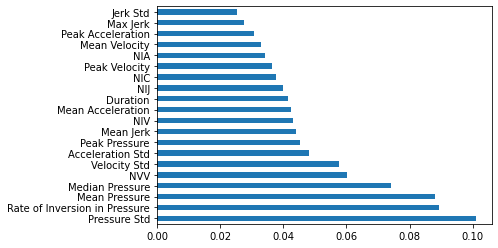

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(Xcols,ycols)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=Xcols.columns)
#print(feat_importances)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

## Logistic Regression

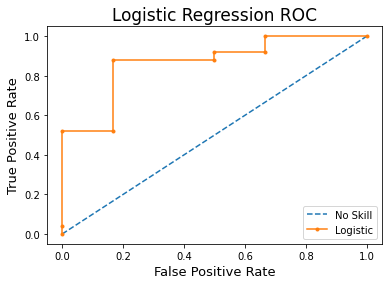

In [ ]:
# 1. import
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import roc_curve

# 2. instantiate model
feature_cols = features_df_static.columns[2:].values
X = features_df_static.loc[:, feature_cols].values
y = features_df_static.Category.values

trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.4, random_state=1000)

logreg = LogisticRegression(solver='lbfgs', max_iter = 1200000)

# 3. fit 
logreg.fit(trainX, trainy)

pred_class = logreg.predict(testX)
pred_probs = logreg.predict_proba(testX)
pred_probs = pred_probs[:, 1]

# 4. calculate scores

# generate a no skill prediction (majority class)
random_probs = [1 for _ in range(len(testy))]

random_auc = roc_auc_score(testy, random_probs)
model_log_auc = roc_auc_score(testy, pred_probs)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, random_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, pred_probs)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('False Positive Rate', fontsize = 13)
pyplot.ylabel('True Positive Rate', fontsize = 13)
pyplot.title('Logistic Regression ROC', fontsize = 17)

# show the legend
pyplot.legend()

# show the plot
pyplot.show()

In [ ]:
print(model_log_auc)

0.8666666666666667


## SVM

In [ ]:
from sklearn.svm import SVC

trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.4, random_state=1)

svclassifier = SVC(kernel='linear', probability = True)

svclassifier.fit(trainX, trainy)

pred_class = svclassifier.predict(testX)
pred_probs = svclassifier.predict_proba(testX)
pred_probs = pred_probs[:, 1]


# generate a no skill prediction (majority class)
random_probs = [1 for _ in range(len(testy))]

random_auc = roc_auc_score(testy, random_probs)
model_svc_auc = roc_auc_score(testy, pred_probs)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, random_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, pred_probs)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('False Positive Rate', fontsize = 13)
pyplot.ylabel('True Positive Rate', fontsize = 13)
pyplot.title('SVM', fontsize = 17)

# show the legend
pyplot.legend()

# show the plot
pyplot.show()

KeyboardInterrupt: 

In [ ]:
print (model_svc_auc)

0.8793103448275862


## Different Types of Classifiers

In [ ]:
###############################################################################
#                          1. Importing Libraries                             #
###############################################################################
# For reading, visualizing, and preprocessing data
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

# Classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

In [ ]:
###############################################################################
#                                 2. Get data                                 #
###############################################################################
# Numpy array to pandas dataframe
feature_cols = features_df_static.columns[2:].values
X = features_df_static.loc[:, feature_cols].values
y = features_df_static.Category.values
X = pd.DataFrame(X, columns = feature_cols)
y = pd.DataFrame(y, columns = ['Category'])

In [ ]:
###############################################################################
#                        3. Create train and test set                         #
###############################################################################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,
                                                    random_state = 1000)

In [ ]:
###############################################################################
#                               4. Classifiers                                #
###############################################################################
# Create list of tuples with classifier label and classifier object
classifiers = {}
classifiers.update({"LDA": LinearDiscriminantAnalysis()})
classifiers.update({"QDA": QuadraticDiscriminantAnalysis()})
classifiers.update({"AdaBoost": AdaBoostClassifier()})
classifiers.update({"Bagging": BaggingClassifier()})
classifiers.update({"Extra Trees Ensemble": ExtraTreesClassifier()})
classifiers.update({"Gradient Boosting": GradientBoostingClassifier()})
classifiers.update({"Random Forest": RandomForestClassifier()})
classifiers.update({"Ridge": RidgeClassifier()})
classifiers.update({"SGD": SGDClassifier()})
classifiers.update({"BNB": BernoulliNB()})
classifiers.update({"GNB": GaussianNB()})
classifiers.update({"KNN": KNeighborsClassifier()})
classifiers.update({"MLP": MLPClassifier()})
classifiers.update({"LSVC": LinearSVC()})
classifiers.update({"NuSVC": NuSVC()})
classifiers.update({"SVC": SVC()})
classifiers.update({"DTC": DecisionTreeClassifier()})
classifiers.update({"ETC": ExtraTreeClassifier()})

# Create dict of decision function labels
DECISION_FUNCTIONS = {"Ridge", "SGD", "LSVC", "NuSVC", "SVC"}

# Create dict for classifiers with feature_importances_ attribute
FEATURE_IMPORTANCE = {"Gradient Boosting", "Extra Trees Ensemble", "Random Forest"}

In [ ]:
###############################################################################
#                             5. Hyper-parameters                             #
###############################################################################
# Initiate parameter grid
parameters = {}

# Update dict with LDA
parameters.update({"LDA": {"classifier__solver": ["svd"], 
                                         }})

# Update dict with QDA
parameters.update({"QDA": {"classifier__reg_param":[0.01*ii for ii in range(0, 101)], 
                                         }})
# Update dict with AdaBoost
parameters.update({"AdaBoost": { 
                                "classifier__base_estimator": [DecisionTreeClassifier(max_depth = ii) for ii in range(1,6)],
                                "classifier__n_estimators": [200],
                                "classifier__learning_rate": [0.001, 0.01, 0.05, 0.1, 0.25, 0.50, 0.75, 1.0]
                                 }})

# Update dict with Bagging
parameters.update({"Bagging": { 
                                "classifier__base_estimator": [DecisionTreeClassifier(max_depth = ii) for ii in range(1,6)],
                                "classifier__n_estimators": [200],
                                "classifier__max_features": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                "classifier__n_jobs": [-1]
                                }})

# Update dict with Gradient Boosting
parameters.update({"Gradient Boosting": { 
                                        "classifier__learning_rate":[0.15,0.1,0.05,0.01,0.005,0.001], 
                                        "classifier__n_estimators": [200],
                                        "classifier__max_depth": [2,3,4,5,6],
                                        "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                                        "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                                        "classifier__max_features": ["auto", "sqrt", "log2"],
                                        "classifier__subsample": [0.8, 0.9, 1]
                                         }})


# Update dict with Extra Trees
parameters.update({"Extra Trees Ensemble": { 
                                            "classifier__n_estimators": [200],
                                            "classifier__class_weight": [None, "balanced"],
                                            "classifier__max_features": ["auto", "sqrt", "log2"],
                                            "classifier__max_depth" : [3, 4, 5, 6, 7, 8],
                                            "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                                            "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                                            "classifier__criterion" :["gini", "entropy"]     ,
                                            "classifier__n_jobs": [-1]
                                             }})


# Update dict with Random Forest Parameters
parameters.update({"Random Forest": { 
                                    "classifier__n_estimators": [200],
                                    "classifier__class_weight": [None, "balanced"],
                                    "classifier__max_features": ["auto", "sqrt", "log2"],
                                    "classifier__max_depth" : [3, 4, 5, 6, 7, 8],
                                    "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                                    "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                                    "classifier__criterion" :["gini", "entropy"]     ,
                                    "classifier__n_jobs": [-1]
                                     }})

# Update dict with Ridge
parameters.update({"Ridge": { 
                            "classifier__alpha": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.50, 0.75, 1.0]
                             }})

# Update dict with SGD Classifier
parameters.update({"SGD": { 
                            "classifier__alpha": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.50, 0.75, 1.0],
                            "classifier__penalty": ["l1", "l2"],
                            "classifier__n_jobs": [-1]
                             }})


# Update dict with BernoulliNB Classifier
parameters.update({"BNB": { 
                            "classifier__alpha": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.50, 0.75, 1.0]
                             }})

# Update dict with GaussianNB Classifier
parameters.update({"GNB": { 
                            "classifier__var_smoothing": [1e-9, 1e-8,1e-7, 1e-6, 1e-5]
                             }})

# Update dict with K Nearest Neighbors Classifier
parameters.update({"KNN": { 
                            "classifier__n_neighbors": list(range(1,31)),
                            "classifier__p": [1, 2, 3, 4, 5],
                            "classifier__leaf_size": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                            "classifier__n_jobs": [-1]
                             }})

# Update dict with MLPClassifier
parameters.update({"MLP": { 
                            "classifier__hidden_layer_sizes": [(5), (10), (5,5), (10,10), (5,5,5), (10,10,10)],
                            "classifier__activation": ["identity", "logistic", "tanh", "relu"],
                            "classifier__learning_rate": ["constant", "invscaling", "adaptive"],
                            "classifier__max_iter": [100, 200, 300, 500, 1000, 2000],
                            "classifier__alpha": list(10.0 ** -np.arange(1, 10)),
                             }})

parameters.update({"LSVC": { 
                            "classifier__penalty": ["l2"],
                            "classifier__C": [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100]
                             }})

parameters.update({"NuSVC": { 
                            "classifier__nu": [0.25, 0.50, 0.75],
                            "classifier__kernel": ["linear", "rbf", "poly"],
                            "classifier__degree": [1,2,3,4,5,6],
                             }})

parameters.update({"SVC": { 
                            "classifier__kernel": ["linear", "rbf", "poly"],
                            "classifier__gamma": ["auto"],
                            "classifier__C": [0.1, 0.5, 1, 5, 10, 50, 100],
                            "classifier__degree": [1, 2, 3, 4, 5, 6]
                             }})


# Update dict with Decision Tree Classifier
parameters.update({"DTC": { 
                            "classifier__criterion" :["gini", "entropy"],
                            "classifier__splitter": ["best", "random"],
                            "classifier__class_weight": [None, "balanced"],
                            "classifier__max_features": ["auto", "sqrt", "log2"],
                            "classifier__max_depth" : [1,2,3, 4, 5, 6, 7, 8],
                            "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                            "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                             }})

# Update dict with Extra Tree Classifier
parameters.update({"ETC": { 
                            "classifier__criterion" :["gini", "entropy"],
                            "classifier__splitter": ["best", "random"],
                            "classifier__class_weight": [None, "balanced"],
                            "classifier__max_features": ["auto", "sqrt", "log2"],
                            "classifier__max_depth" : [1,2,3, 4, 5, 6, 7, 8],
                            "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                            "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                             }})

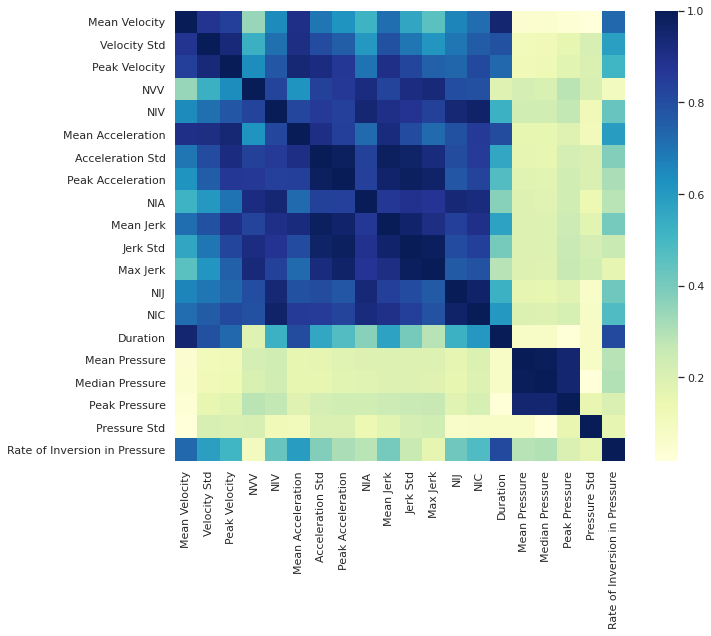

In [ ]:
###############################################################################
#              6. Feature Selection: Removing highly correlated features      #
###############################################################################
# Filter Method: Spearman's Cross Correlation > 0.95
# Make correlation matrix
corr_matrix = X_train.corr(method = "spearman").abs()

# Draw the heatmap
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax = ax)
f.tight_layout()
plt.savefig("correlation_matrix.png", dpi = 1080)

# Select upper triangle of matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features
X_train = X_train.drop(to_drop, axis = 1)
X_test = X_test.drop(to_drop, axis = 1)

In [ ]:
###############################################################################
#                                Base Estimators                              #
###############################################################################
# Create dict for classifiers with feature_importances_ attribute
FEATURE_IMPORTANCE = {"Gradient Boosting", "Extra Trees Ensemble", "Random Forest"}

In [ ]:
###############################################################################
#                     7. Tuning a classifier to use with RFECV                #
###############################################################################
# Define classifier to use as the base of the recursive feature elimination algorithm
selected_classifier = "Random Forest"
classifier = classifiers[selected_classifier]

# Tune classifier (Took = 4.8 minutes)
    
# Scale features via Z-score normalization
scaler = StandardScaler()

# Define steps in pipeline
steps = [("scaler", scaler), ("classifier", classifier)]

# Initialize Pipeline object
pipeline = Pipeline(steps = steps)
  
# Define parameter grid
param_grid = parameters[selected_classifier]

# Initialize GridSearch object
gscv = GridSearchCV(pipeline, param_grid, cv = 5,  n_jobs= -1, verbose = 1, scoring = "roc_auc")
                  
# Fit gscv
print(f"Now tuning {selected_classifier}. Go grab a beer or something.")
gscv.fit(X_train, np.ravel(y_train))  

# Get best parameters and score
best_params = gscv.best_params_
best_score = gscv.best_score_
        
# Update classifier parameters
tuned_params = {item[12:]: best_params[item] for item in best_params}
classifier.set_params(**tuned_params)

Now tuning Random Forest. Go grab a beer or something.
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 26.9min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 36.5min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 49.1min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 60.4min
[Parallel(n_jobs=-1)]: Done 4996 tasks      | elapsed: 73.9min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed: 84.0min finished


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=8, max_features='log2', min_samples_leaf=0.01,
                       min_samples_split=0.005, n_estimators=200, n_jobs=-1)

In [ ]:
###############################################################################
#                  8. Custom pipeline object to use with RFECV                #
###############################################################################
# Select Features using RFECV
class PipelineRFE(Pipeline):
    # Source: https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/
    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self

In [ ]:
###############################################################################
#   9. Feature Selection: Recursive Feature Selection with Cross Validation   #
###############################################################################
# Define pipeline for RFECV
steps = [("scaler", scaler), ("classifier", classifier)]
pipe = PipelineRFE(steps = steps)

# Initialize RFECV object
feature_selector = RFECV(pipe, cv = 5, step = 1, scoring = "roc_auc", verbose = 1)

# Fit RFECV
feature_selector.fit(X_train, np.ravel(y_train))

# Get selected features
feature_names = X_train.columns
selected_features = feature_names[feature_selector.support_].tolist()

Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting 

In [ ]:
###############################################################################
#                             10. Performance Curve                           #
###############################################################################
# Get Performance Data
performance_curve = {"Number of Features": list(range(1, len(feature_names) + 1)),
                    "AUC": feature_selector.grid_scores_}
performance_curve = pd.DataFrame(performance_curve)

# Performance vs Number of Features
# Set graph style
sns.set(font_scale = 1.75)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})
colors = sns.color_palette("RdYlGn", 20)
line_color = colors[3]
marker_colors = colors[-1]

# Plot
f, ax = plt.subplots(figsize=(13, 6.5))
sns.lineplot(x = "Number of Features", y = "AUC", data = performance_curve,
             color = line_color, lw = 4, ax = ax)
sns.regplot(x = performance_curve["Number of Features"], y = performance_curve["AUC"],
            color = marker_colors, fit_reg = False, scatter_kws = {"s": 200}, ax = ax)

# Axes limits
plt.xlim(0.5, len(feature_names)+0.5)
plt.ylim(0.4, 0.95)

# Generate a bolded horizontal line at y = 0
ax.axhline(y = 0.5, color = 'black', linewidth = 1.3, alpha = .7)

# Turn frame off
ax.set_frame_on(False)

# Tight layout
plt.tight_layout()

# Save Figure
plt.savefig("performance_curve.png", dpi = 1080)

AttributeError: 'RFE' object has no attribute 'grid_scores_'

In [ ]:
###############################################################################
#                11. Feature Selection: Recursive Feature Selection           #
###############################################################################
# Define pipeline for RFECV
steps = [("scaler", scaler), ("classifier", classifier)]
pipe = PipelineRFE(steps = steps)

# Initialize RFE object
feature_selector = RFE(pipe, n_features_to_select = 10, step = 1, verbose = 1)

# Fit RFE
feature_selector.fit(X_train, np.ravel(y_train))

# Get selected features labels
feature_names = X_train.columns
selected_features = feature_names[feature_selector.support_].tolist()

Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.


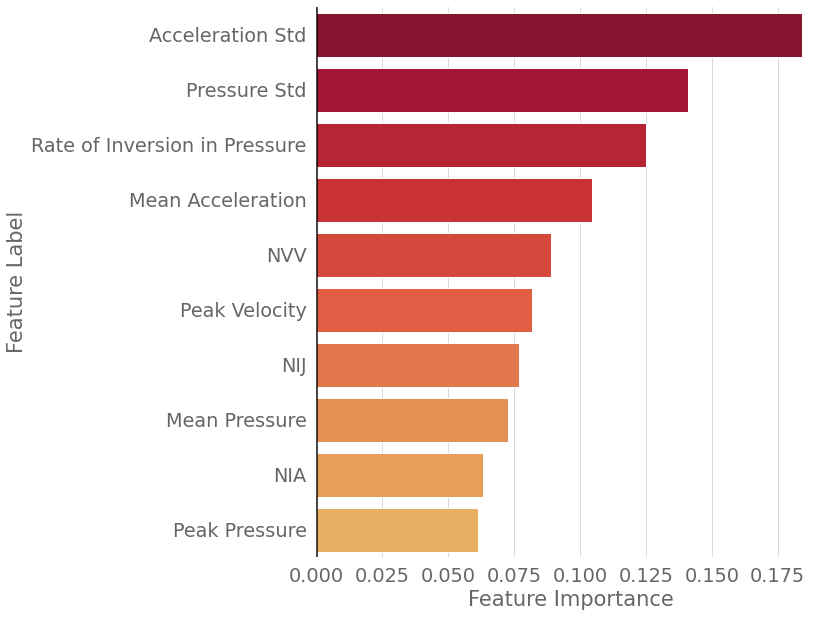

In [ ]:
###############################################################################
#                  12. Visualizing Selected Features Importance               #
###############################################################################
# Get selected features data set
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# Train classifier
classifier.fit(X_train, np.ravel(y_train))

# Get feature importance
feature_importance = pd.DataFrame(selected_features, columns = ["Feature Label"])
feature_importance["Feature Importance"] = classifier.feature_importances_

# Sort by feature importance
feature_importance = feature_importance.sort_values(by="Feature Importance", ascending=False)

# Set graph style
sns.set(font_scale = 1.75)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})

# Set figure size and create barplot
f, ax = plt.subplots(figsize=(12, 9))
sns.barplot(x = "Feature Importance", y = "Feature Label",
            palette = reversed(sns.color_palette('YlOrRd', 15)),  data = feature_importance)

# Generate a bolded horizontal line at y = 0
ax.axvline(x = 0, color = 'black', linewidth = 4, alpha = .7)

# Turn frame off
ax.set_frame_on(False)

# Tight layout
plt.tight_layout()

# Save Figure
plt.savefig("feature_importance.png", dpi = 1080)

In [ ]:
###############################################################################
#                       13. Classifier Tuning and Evaluation                  #
###############################################################################
# Initialize dictionary to store results
results = {}

# Tune and evaluate classifiers
for classifier_label, classifier in classifiers.items():
    # Print message to user
    print(f"Now tuning {classifier_label}.")
    
    # Scale features via Z-score normalization
    scaler = StandardScaler()
    
    # Define steps in pipeline
    steps = [("scaler", scaler), ("classifier", classifier)]
    
    # Initialize Pipeline object
    pipeline = Pipeline(steps = steps)
      
    # Define parameter grid
    param_grid = parameters[classifier_label]
    
    # Initialize GridSearch object
    gscv = GridSearchCV(pipeline, param_grid, cv = 5,  n_jobs= -1, verbose = 1, scoring = "roc_auc")
                      
    # Fit gscv
    gscv.fit(X_train, np.ravel(y_train))  
    
    # Get best parameters and score
    best_params = gscv.best_params_
    best_score = gscv.best_score_
    
    # Update classifier parameters and define new pipeline with tuned classifier
    tuned_params = {item[12:]: best_params[item] for item in best_params}
    classifier.set_params(**tuned_params)
            
    # Make predictions
    if classifier_label in DECISION_FUNCTIONS:
        y_pred = gscv.decision_function(X_test)
    else:
        y_pred = gscv.predict_proba(X_test)[:,1]
    
    # Evaluate model
    auc = metrics.roc_auc_score(y_test, y_pred)
    
    # Save results
    result = {"Classifier": gscv,
              "Best Parameters": best_params,
              "Training AUC": best_score,
              "Test AUC": auc}
    
    results.update({classifier_label: result})

# Dynamic Drawings

In [ ]:
subject_id = []
mean_vel = []
median_vel = []
max_vel = []
vel_std = []
vel_niv = []
nvv = []
mean_accel = []
max_accel = []
median_accel = []
std_accel = []
nia_accel = []
mean_jerk = []  
max_jerk = []
median_jerk = []
std_jerk = []
nij = []
nic = []
mean_pressure = []
median_pressure = []
max_pressure = []
std_pressure = []
#total_displacement = []
duration = []
category = []

# all the control dynamic drawings
for i in range(1, 16): 
    if i < 10: 
        df = pd.read_csv('/work/ParkinsonHW/C_000' + str(i) + '.txt', sep = ';', header = None)
    else: 
        df = pd.read_csv('/work/ParkinsonHW/C_00' + str(i) + '.txt', sep = ';', header = None)
    df_dynamic = df[(df[6] == 1)]
    x = df_dynamic[0]
    y = df_dynamic[1]
    t = df_dynamic[5]
    curve = np.array([x, y])
    velocity = smoothCurveFeature(curve, n, smoothing_factor)[0]
    acceleration = smoothCurveFeature(curve, n, smoothing_factor)[1]
    jerk = smoothCurveFeature(curve, n, smoothing_factor)[2]
    curvature = smoothCurveFeature(curve, n, smoothing_factor)[3]
    pressure = df_dynamic[3]
    timestamps = list(df_dynamic[5])
    
    subject_id.append('C' + str(i))

    mean_vel.append(velocity_mean(velocity))
    median_vel.append(velocity_median(velocity))
    max_vel.append(velocity_max(velocity))
    vel_std.append(velocity_std(velocity))
    vel_niv.append(velocity_niv(velocity))
    nvv.append(velocity_nvv(velocity))

    mean_accel.append(accel_mean(acceleration))
    median_accel.append(accel_median(acceleration))
    max_accel.append(accel_max(acceleration))
    std_accel.append(accel_std(acceleration))
    nia_accel.append(accel_nia(acceleration))

    mean_jerk.append(jerk_mean(jerk))
    median_jerk.append(jerk_median(jerk))
    max_jerk.append(jerk_max(jerk))
    std_jerk.append(jerk_std(jerk))
    nij.append(jerk_nij(jerk))

    nic.append(curvature_nic(curvature))

    duration.append(duration_calc(timestamps))
    #total_displacement.append(total_displacement_calc(displacement))

    mean_pressure.append(pressure_mean(pressure))
    max_pressure.append(pressure_max(pressure))
    median_pressure.append(pressure_median(pressure))
    std_pressure.append(pressure_std(pressure))

    category.append(0)

# all the PD dynamic drawings 
directory = os.fsencode('/work/ParkinsonHW')
for file in os.listdir(directory): 
    filename = os.fsdecode(file)
    if filename[0] == 'P' or filename[0] == 'H': 
        path = os.path.join('/work/ParkinsonHW', filename)
        df = pd.read_csv(path, sep = ';', header = None)
        
        if 1 not in list(df[6]):
            continue
        df_dynamic = df[(df[6]==1)]
        x = df_dynamic[0]
        y = df_dynamic[1]
        t = df_dynamic[5]
        
        curve = np.array([x, y])
        velocity = smoothCurveFeature(curve, n, smoothing_factor)[0]
        acceleration = smoothCurveFeature(curve, n, smoothing_factor)[1]
        jerk = smoothCurveFeature(curve, n, smoothing_factor)[2]
        curvature = smoothCurveFeature(curve, n, smoothing_factor)[3]
        pressure = df_dynamic[3]
        timestamps = df_dynamic[5]
        
        subject_id.append(filename[:-4])

        mean_vel.append(velocity_mean(velocity))
        median_vel.append(velocity_median(velocity))
        max_vel.append(velocity_max(velocity))
        vel_std.append(velocity_std(velocity))
        vel_niv.append(velocity_niv(velocity))
        nvv.append(velocity_nvv(velocity))

        mean_accel.append(accel_mean(acceleration))
        median_accel.append(accel_median(acceleration))
        max_accel.append(accel_max(acceleration))
        std_accel.append(accel_std(acceleration))
        nia_accel.append(accel_nia(acceleration))

        mean_jerk.append(jerk_mean(jerk))
        median_jerk.append(jerk_median(jerk))
        max_jerk.append(jerk_max(jerk))
        std_jerk.append(jerk_std(jerk))
        nij.append(jerk_nij(jerk))

        nic.append(curvature_nic(curvature))

        duration.append(duration_calc(timestamps))
        #total_displacement.append(total_displacement_calc(displacement))

        mean_pressure.append(pressure_mean(pressure))
        max_pressure.append(pressure_max(pressure))
        median_pressure.append(pressure_median(pressure))
        std_pressure.append(pressure_std(pressure))

        # 1 meaning patient data
        category.append(1)

features_df_dynamic = pd.DataFrame({
'Subject ID': subject_id,
'Category' : category,
'Mean Velocity': mean_vel, 'Velocity Std': vel_std, 'Peak Velocity': max_vel, 'NVV': nvv, 'NIV': vel_niv, 
'Mean Acceleration': mean_accel, 'Acceleration Std': std_accel, 'Peak Acceleration': max_accel, 'NIA': nia_accel, 
'Mean Jerk': mean_jerk, 'Jerk Std': std_jerk, 'Max Jerk': max_jerk, 'NIJ': nij, 
'NIC': nic, 
'Duration': duration, 
#'Total Displacement': total_displacement, 
'Mean Pressure': mean_pressure, 'Median Pressure': median_pressure, 'Peak Pressure': max_pressure, 'Pressure Std': std_pressure, 
}) 

(array([  86,  483,  661, 1060, 1221, 1407, 1644, 1879, 2190, 2484, 3005,
       3185, 3412, 3589, 3966, 4144, 4368, 4525, 4671]),)
(array([ 313,  509,  595,  906, 1023, 1185, 1278, 1471, 1880, 2042, 2233,
       2360, 2645, 2827, 2991, 3200, 3402, 3894, 4124, 4368, 4744]),)
(array([ 106,  334,  575,  777, 1266, 1445, 1639, 1758, 1879, 1994, 2121,
       2332, 2492, 2595, 2761, 2952, 3083, 3217, 3377, 3546, 3743, 3871,
       4221, 4488, 4641, 4764]),)
(array([  76,  509,  662,  856, 1252, 1510, 1884, 2078, 2316, 2548, 2748,
       3096, 3247, 3422, 3743, 3899, 4005, 4457, 4644, 4746, 4948]),)
(array([ 370,  956, 1241, 1375, 1651, 2040, 2463, 2844, 3205, 3676, 4464,
       4679]),)
(array([ 322,  679, 1248, 1560, 2018, 2390, 2878, 3149, 3641, 3805, 4257,
       4522, 4697]),)
(array([ 374,  607,  821, 1228, 1393, 1642, 1885, 2288, 2429, 2587, 2742,
       3089, 3277, 3659, 3829, 4214, 4455, 4596, 4802]),)
(array([  50,  200,  308,  427,  542,  630,  743,  799,  834,  897,  958,
       

In [ ]:
features_df_dynamic

Subject ID  Category  Mean Velocity  Velocity Std  Peak Velocity  \
0            C1         0       0.595046      0.168319       1.133166   
1            C2         0       0.556302      0.159552       1.059333   
2            C3         0       0.521668      0.180438       1.316628   
3            C4         0       0.625975      0.261397       1.567060   
4            C5         0       0.873616      0.309551       1.656355   
..          ...       ...            ...           ...            ...   
67  H_P000-0040         1       3.164286      1.999002       9.176623   
68   P_26060007         1       0.658202      0.469963       2.488131   
69  H_P000-0035         1       2.487650      2.071271      20.619564   
70   P_23100002         1       1.021080      0.448754       2.372830   
71  H_P000-0032         1       0.849734      0.303323       2.100488   

         NVV       NIV  Mean Acceleration  Acceleration Std  \
0   0.000626  0.000838           0.005145          0.003314   
1   0.000714  0.000896           0.004803          0.003199   
2   0.000617  0.000712           0.004498          0.004079   
3   0.000959  0.000965           0.006862          0.009224   
4   0.000532  0.000767           0.008555          0.005050   
..       ...       ...                ...               ...   
67  0.003254  0.005038           0.159594          0.106317   
68  0.000955  0.000896           0.008774          0.009100   
69  0.026562  0.011428           0.612610          0.665862   
70  0.000522  0.000629           0.013289          0.006721   
71  0.001692  0.001789           0.016432          0.015961   

    Peak Acceleration  ...  Mean Jerk  Jerk Std  Max Jerk       NIJ       NIC  \
0            0.028435  ...   0.000150  0.000209  0.001916  0.002117  0.001147   
1            0.016771  ...   0.000159  0.000179  0.001143  0.002006  0.001067   
2            0.047702  ...   0.000174  0.000248  0.002133  0.001697  0.000930   
3            0.232481  ...   0.000344  0.001275  0.025565  0.002390  0.001241   
4            0.047715  ...   0.000177  0.000184  0.001438  0.001981  0.001087   
..                ...  ...        ...       ...       ...       ...       ...   
67           0.603546  ...   0.018083  0.016133  0.102768  0.010831  0.005038   
68           0.057028  ...   0.000421  0.000581  0.004342  0.002240  0.001172   
69           8.066041  ...   0.200966  0.236465  2.204616  0.015930  0.010158   
70           0.037969  ...   0.000317  0.000214  0.001454  0.001742  0.001064   
71           0.242514  ...   0.001139  0.001346  0.015392  0.004216  0.002044   

    Duration  Mean Pressure  Median Pressure  Peak Pressure  Pressure Std  
0      22670     910.966791            938.0            982     83.350049  
1      23429     926.910511            971.0           1007     94.649093  
2      36541     912.727945            953.0            980     78.160580  
3      21761     939.670546            928.0           1023     96.374974  
4      15645     953.766637            990.0           1023     88.489533  
..       ...            ...              ...            ...           ...  
67      3970     856.959075            891.0            983    117.385532  
68     29014     618.274002            645.0            714     93.023929  
69     17326     708.251546            728.0            908     95.450339  
70     20671     935.983014            966.0           1023    104.515016  
71     15653     832.302472            868.0            920    109.974284  

[72 rows x 21 columns]

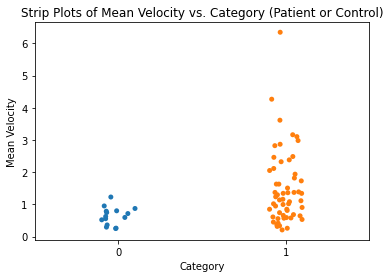

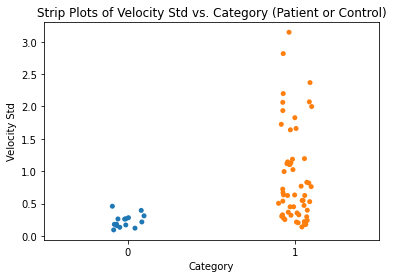

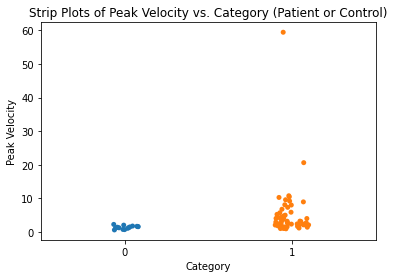

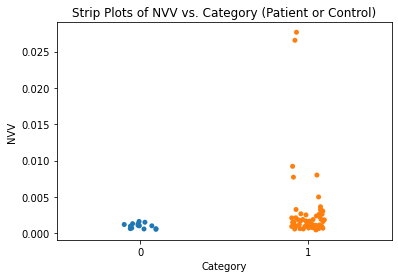

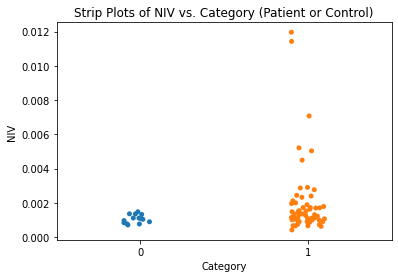

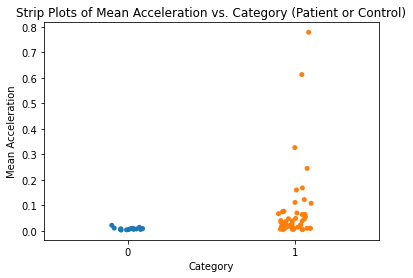

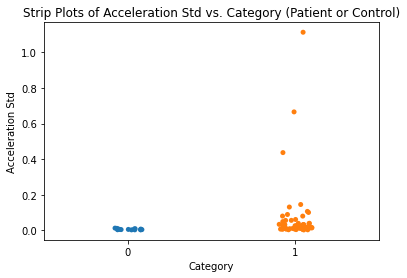

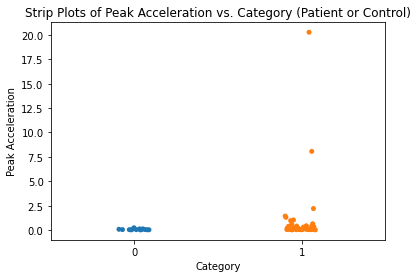

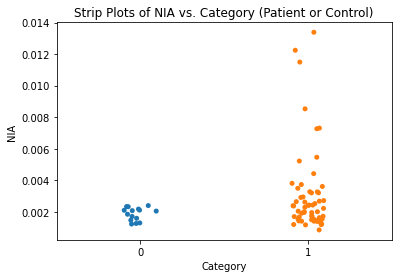

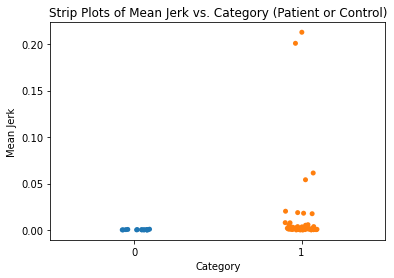

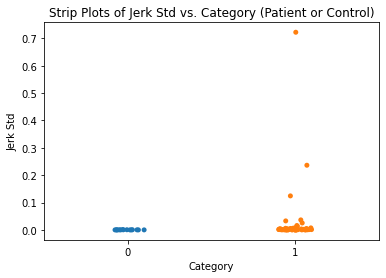

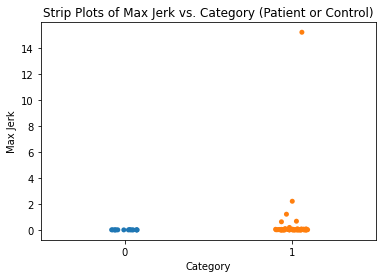

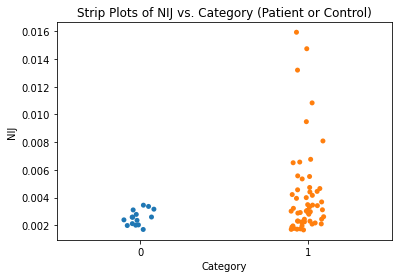

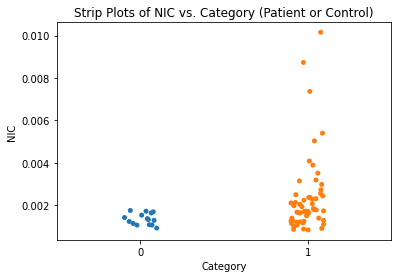

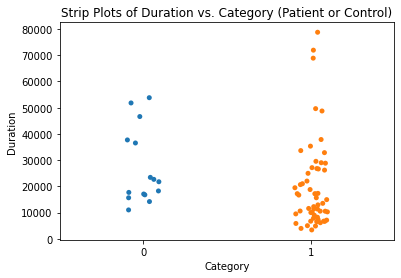

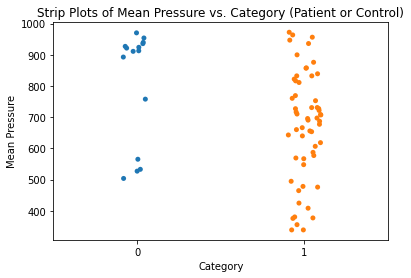

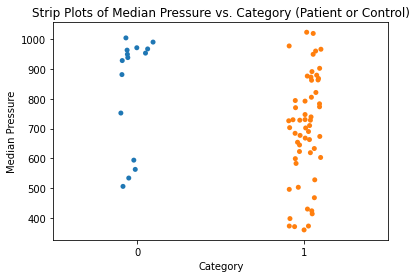

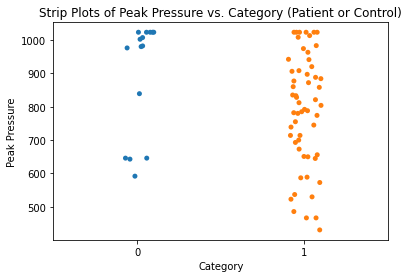

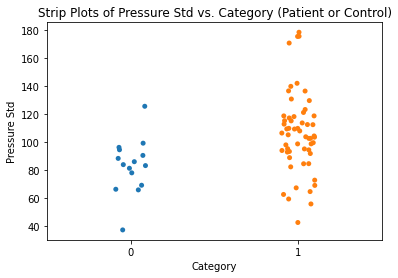

In [ ]:
for i in features_df_dynamic.columns[2:]: 
    plt.figure()
    plt.title('Strip Plots of {} vs. Category (Patient or Control)'.format(i))
    sns.stripplot(x = features_df_dynamic['Category'], y = features_df_dynamic[i])

## Logistic Regression

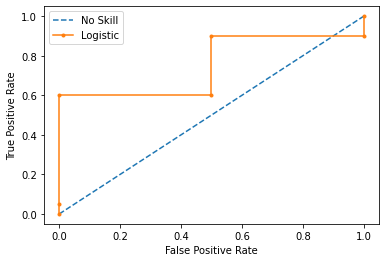

In [ ]:
# 2. instantiate model
feature_cols = features_df_dynamic.columns[2:].values
X = features_df_dynamic.loc[:, feature_cols].values
y = features_df_dynamic.Category.values

trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.3, random_state=7)

logreg = LogisticRegression(solver='lbfgs', max_iter = 1200000)

# 3. fit 
logreg.fit(trainX, trainy)

pred_class = logreg.predict(testX)
pred_probs = logreg.predict_proba(testX)
pred_probs = pred_probs[:, 1]

# 4. calculate scores

# generate a no skill prediction (majority class)
random_probs = [1 for _ in range(len(testy))]

random_auc = roc_auc_score(testy, random_probs)
model_log_auc = roc_auc_score(testy, pred_probs)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, random_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, pred_probs)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

pyplot.legend()

pyplot.show()

In [ ]:
print (model_log_auc)

0.9827586206896552


In [ ]:
import statsmodels.api as sm
logit_model = sm.Logit(y, X)
result = logit_model.fit(method = 'bfgs')
print(result.summary())
print(model_log_auc)

         Current function value: 0.192801
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   72
Model:                          Logit   Df Residuals:                       53
Method:                           MLE   Df Model:                           18
Date:                Wed, 06 Jan 2021   Pseudo R-squ.:                  0.6232
Time:                        22:03:34   Log-Likelihood:                -13.882
converged:                      False   LL-Null:                       -36.845
Covariance Type:            nonrobust   LLR p-value:                 0.0003040
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -7.6415      9.308     -0.821      0.412     -25.884      10.6

## Support Vector Classifier

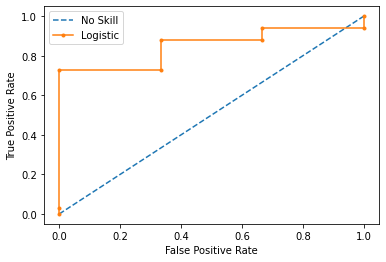

In [ ]:
from sklearn.svm import SVC

trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=1)

svclassifier = SVC(kernel='linear', probability = True)

svclassifier.fit(trainX, trainy)

pred_class = svclassifier.predict(testX)
pred_probs = svclassifier.predict_proba(testX)
pred_probs = pred_probs[:, 1]


# generate a no skill prediction (majority class)
random_probs = [1 for _ in range(len(testy))]

random_auc = roc_auc_score(testy, random_probs)
model_svc_auc = roc_auc_score(testy, pred_probs)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, random_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, pred_probs)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# show the legend
pyplot.legend()

# show the plot
pyplot.show()

In [ ]:
print(model_svc_auc)

0.8383838383838383


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=54ea7590-1f30-42ee-b9c1-c929b94e3f2f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>